In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import pickle
import os
import yfinance as yf
import pandas_datareader as pdr
import random

In [4]:
yf.pdr_override()
ust_index = yf.download('GOVT', start='2016-01-01', end='2022-12-17')
ust_index 

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,25.170000,25.219999,25.090000,25.120001,22.398947,270100
2016-01-05,25.100000,25.129999,25.070000,25.090000,22.372183,272200
2016-01-06,25.180000,25.260000,25.150000,25.190001,22.461357,374000
2016-01-07,25.209999,25.250000,25.150000,25.240000,22.505941,189200
2016-01-08,25.230000,25.290001,25.200001,25.270000,22.532684,2518500
...,...,...,...,...,...,...
2022-12-12,23.180000,23.200001,23.059999,23.080000,23.043285,7923900
2022-12-13,23.330000,23.350000,23.209999,23.230000,23.193047,14265300
2022-12-14,23.250000,23.290001,23.170000,23.260000,23.223000,9833800


In [5]:
ust_index.loc[:, 'return'] = np.log(ust_index.Close/ust_index.Close.shift(1))
ust_index.loc[:, 'cumreturn'] = ust_index.loc[:, 'return'].cumsum().apply(np.exp)
ust_index.loc[:, 'cumreturn'].fillna(1, inplace=True)
ust_index

,Open,High,Low,Close,Adj Close,Volume,return,cumreturn
Date,,,,,,,,
2016-01-04,25.170000,25.219999,25.090000,25.120001,22.398947,270100,NaN,1.000000
2016-01-05,25.100000,25.129999,25.070000,25.090000,22.372183,272200,-0.001195,0.998806
2016-01-06,25.180000,25.260000,25.150000,25.190001,22.461357,374000,0.003978,1.002787
2016-01-07,25.209999,25.250000,25.150000,25.240000,22.505941,189200,0.001983,1.004777
2016-01-08,25.230000,25.290001,25.200001,25.270000,22.532684,2518500,0.001188,1.005971
...,...,...,...,...,...,...,...,...
2022-12-12,23.180000,23.200001,23.059999,23.080000,23.043285,7923900,-0.000866,0.918790
2022-12-13,23.330000,23.350000,23.209999,23.230000,23.193047,14265300,0.006478,0.924761
2022-12-14,23.250000,23.290001,23.170000,23.260000,23.223000,9833800,0.001291,0.925955


In [6]:
ust_index.loc[ust_index.index < '2021-01-01', :]

,Open,High,Low,Close,Adj Close,Volume,return,cumreturn
Date,,,,,,,,
2016-01-04,25.170000,25.219999,25.090000,25.120001,22.398947,270100,NaN,1.000000
2016-01-05,25.100000,25.129999,25.070000,25.090000,22.372183,272200,-0.001195,0.998806
2016-01-06,25.180000,25.260000,25.150000,25.190001,22.461357,374000,0.003978,1.002787
2016-01-07,25.209999,25.250000,25.150000,25.240000,22.505941,189200,0.001983,1.004777
2016-01-08,25.230000,25.290001,25.200001,25.270000,22.532684,2518500,0.001188,1.005971
...,...,...,...,...,...,...,...,...
2020-12-24,27.330000,27.360001,27.330000,27.340000,26.623741,1923000,0.000366,1.088376
2020-12-28,27.309999,27.360001,27.290001,27.350000,26.633482,3489600,0.000366,1.088774
2020-12-29,27.309999,27.360001,27.309999,27.350000,26.633482,4165600,0.000000,1.088774


In [7]:
sp500 = yf.download('SPY', start='2005-01-04', end='2022-12-17')
sp500 = sp500.loc[:, ['Close']]
sp500.loc[:, 'inv_wealth'] = sp500.Close.shift(1).ewm(span=180).mean()/sp500.Close
sp500

[*********************100%***********************]  1 of 1 completed


,Close,inv_wealth
Date,,
2005-01-04,118.830002,NaN
2005-01-05,118.010002,1.006949
2005-01-06,118.610001,0.998379
2005-01-07,118.440002,1.000359
2005-01-10,119.000000,0.995561
...,...,...
2022-12-12,398.950012,1.001570
2022-12-13,401.970001,0.994028
2022-12-14,399.399994,1.000491


In [8]:
spot_rates = pd.read_csv(f'{os.path.dirname(os.getcwd())}/spot rates.csv', header=0, index_col=0, parse_dates=[0])
spot_rates

,1 Mo,3 Mo,6 Mo,1 Yr,1.5 Yr,2 Yr,2.5 Yr,3 Yr,3.5 Yr,4 Yr,...,15.5 Yr,16 Yr,16.5 Yr,17 Yr,17.5 Yr,18 Yr,18.5 Yr,19 Yr,19.5 Yr,20 Yr
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-04,2.005,2.254500,2.63,2.841363,3.027602,3.233587,3.326710,3.420809,3.498336,3.606612,...,4.842699,4.885567,4.929747,4.975366,5.022561,5.071480,5.122285,5.175149,5.230262,5.287831
2005-01-05,1.974,2.296528,2.63,2.851581,3.050715,3.254094,3.343259,3.430722,3.488118,3.611481,...,4.928161,4.994564,5.057404,5.114665,5.164196,5.203726,5.230884,5.243241,5.238368,5.213911
2005-01-06,2.005,2.320000,2.63,2.841363,3.030181,3.212694,3.304574,3.400045,3.450037,3.583565,...,4.872529,4.935069,4.995920,5.053545,5.106303,5.152446,5.190127,5.217417,5.232331,5.232870
2005-01-07,2.005,2.330000,2.63,2.841363,3.034050,3.233510,3.334549,3.441946,3.505610,3.622425,...,4.868598,4.931184,4.992077,5.049745,5.102545,5.148734,5.186466,5.213815,5.228798,5.229417
2005-01-10,2.015,2.330000,2.67,2.881956,3.073422,3.263835,3.359675,3.451173,3.507568,3.629274,...,4.889944,4.952733,5.012630,5.067843,5.116460,5.156461,5.185729,5.202085,5.203324,5.187282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12,3.728,4.245000,4.78,4.806720,4.614259,4.429216,4.280718,4.123517,4.079583,3.960123,...,3.803924,3.816281,3.828301,3.840133,3.851928,3.863844,3.876040,3.888682,3.901942,3.915996
2022-12-13,3.778,4.249734,4.70,4.693752,4.482063,4.254096,4.114267,3.981635,3.905424,3.824444,...,3.734331,3.789045,3.839170,3.881893,3.914267,3.933254,3.935774,3.918796,3.879438,3.815107
2022-12-14,3.772,4.263989,4.68,4.693984,4.478295,4.264775,4.116872,3.960233,3.908401,3.802997,...,3.656525,3.685458,3.713845,3.740942,3.765976,3.788139,3.806595,3.820483,3.828919,3.831005


In [9]:
real_par_rates = pd.read_csv(f'{os.path.dirname(os.getcwd())}/real par rates.csv', header=0, index_col=0, parse_dates=[0]).iloc[1:, :]
real_par_rates

,5 YR,7 YR,10 YR,20 YR
Date,,,,
2005-01-04,1.10,1.40,1.78,2.02
2005-01-05,1.13,1.42,1.79,2.04
2005-01-06,1.12,1.41,1.76,2.03
2005-01-07,1.16,1.45,1.80,2.06
2005-01-10,1.13,1.42,1.77,2.05
...,...,...,...,...
2022-12-12,1.45,1.38,1.33,1.29
2022-12-13,1.35,1.30,1.27,1.28
2022-12-14,1.39,1.34,1.30,1.32


In [10]:
fed_rates = pd.read_csv(f'{os.path.dirname(os.getcwd())}/US fed rates.csv', header=0, index_col=0, parse_dates=[0])
fed_rates.index.name = 'Date'
fed_rates

,DFF
Date,
2005-01-04,2.25
2005-01-05,2.25
2005-01-06,2.25
2005-01-07,2.24
2005-01-08,2.24
...,...
2022-12-12,3.83
2022-12-13,3.83
2022-12-14,3.83


<AxesSubplot:>

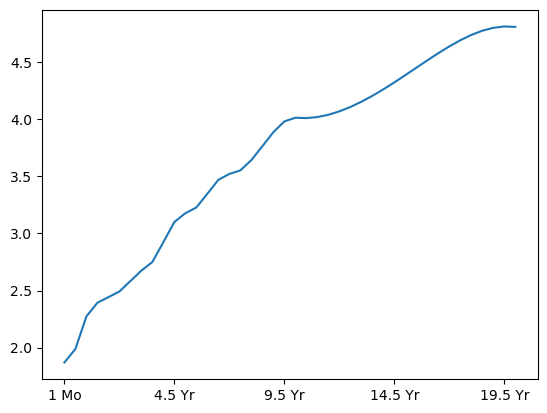

In [21]:
QE_curve = spot_rates.loc[(spot_rates.index >= '2007-08-17') & (spot_rates.index < '2009-01-01'), :].mean(axis=0)
QE_curve.plot()

<AxesSubplot:>

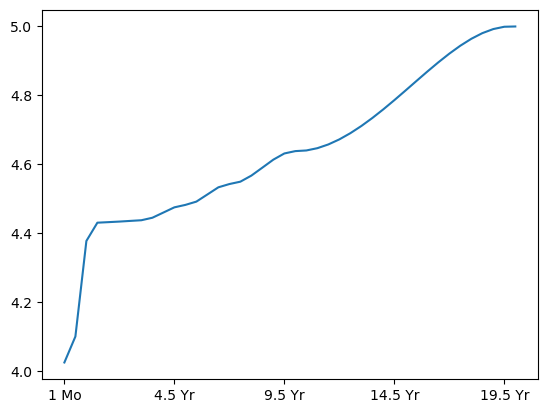

In [22]:
QT_curve = spot_rates.loc[(spot_rates.index < '2007-08-17') | ((spot_rates.index >= '2015-12-16') & (spot_rates.index < '2016-01-01')), :].mean(axis=0)
QT_curve.plot()

<AxesSubplot:>

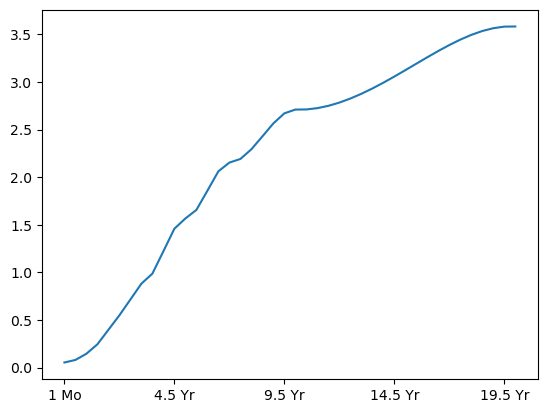

In [23]:
low_rates = spot_rates.loc[(spot_rates.index >= '2009-01-01') & (spot_rates.index < '2015-12-16'), :].mean(axis=0)
low_rates.plot()

In [27]:
tenures = ['1 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr']
years = [1/12, 1/4, 1/2, 1, 2, 3, 5, 7, 10, 20]

In [31]:
term_spreads = []
for tenure in ['3 Mo', '10 Yr', '20 Yr']:
    term_spreads.append(f'{tenure}_slope')

In [33]:
indicators = tenures + ['momentum', 'inv_wealth', 'real 5 yr par', 'real 7 yr par', 'real 10 yr par', 'real 20 yr par', 'EFFR'] + [f'{slope}_diff' for slope in term_spreads]
indicators

['1 Mo',
 '3 Mo',
 '6 Mo',
 '1 Yr',
 '2 Yr',
 '3 Yr',
 '5 Yr',
 '7 Yr',
 '10 Yr',
 '20 Yr',
 'momentum',
 'inv_wealth',
 'real 5 yr par',
 'real 7 yr par',
 'real 10 yr par',
 'real 20 yr par',
 'EFFR',
 '3 Mo_slope_diff',
 '10 Yr_slope_diff',
 '20 Yr_slope_diff']

In [82]:
lag = 100
period = 30

data = spot_rates.merge(sp500, on='Date', how='inner')
data = data.merge(real_par_rates, on='Date', how='inner')
data = data.merge(fed_rates, on='Date', how='inner')
data.rename(columns={'5 YR': 'real 5 yr par',
                    '7 YR': 'real 7 yr par',
                    '10 YR': 'real 10 yr par',
                    '20 YR': 'real 20 yr par',
                    'DFF': 'EFFR'}, inplace=True)

data.loc[:, 'momentum'] = np.where(data['10 Yr']-data['10 Yr'].rolling(180).mean() < -0.05, 1, 0)
data.loc[:, 'momentum'] = np.where(data['10 Yr']-data['10 Yr'].rolling(180).mean() > 0.05, -1, data.momentum)
        
# 0 for QE, 1 for QT, 2 for constant low rates
data.loc[((data.index >= '2007-08-17') & (data.index < '2009-01-01')) |
        ((data.index >= '2019-07-31') & (data.index < '2020-04-01')), 'fed regime'] = 0

data.loc[(data.index < '2007-08-17') | 
         ((data.index >= '2015-12-16') & (data.index < '2019-07-31')) | 
         (data.index >= '2022-03-17'), 'fed regime'] = 1

data.loc[((data.index >= '2009-01-01') & (data.index < '2015-12-16')) |
        ((data.index >= '2020-04-01') & (data.index < '2022-03-17')), 'fed regime'] = 2

for i in [1, 8, 9]:
    data.loc[:, f'{tenures[i]}_slope'] = data.loc[:, tenures[i]] - data.loc[:, tenures[i-1]]
    
# Compare with regime mean
ref_curves = [QE_curve, QT_curve, low_rates]
for i in range(len(ref_curves)):
    curve = ref_curves[i]
    for j in [1, 8, 9]:
        data.loc[data['fed regime']==i, f'{tenures[j]}_slope_diff'] = data.loc[data['fed regime']==i, f'{tenures[j]}_slope'] - (curve.loc[tenures[j]] - curve.loc[tenures[j-1]])
            
for slope in term_spreads:
    data.loc[:, f'{slope}_signal'] = np.where(data[f'{slope}_diff'] > 0, 1, 0)
    data.loc[:, f'{slope}_signal'] = np.where(data[f'{slope}_diff'] < 0, -1, data[f'{slope}_signal'])
    
lagged_indicators = []
for indicator in indicators:
    lagged_indicators.append(indicator)
    for i in range(1, lag):
        data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
        lagged_indicators.append(f'{indicator}_{i}')
            
train = data.loc[(data.index >= '2005-07-01') & (data.index < '2016-01-01'), :]
test = data.loc[data.index >= '2016-01-01', :]

dfs = [train, test]
for df in dfs:
    for i in [1, 8, 9]:
        tenure, year = tenures[i], years[i]
        df.loc[:, f'{tenure} shifted'] = df[tenure].shift(-period+1)
        df.loc[:, f'{tenure} MTM PnL'] = (np.power((1+df[tenure]/100)/(1+df[f'{tenure} shifted']/100), year) - 1).shift(-1)

C:\Users\kmlee\AppData\Local\Temp\ipykernel_5320\1451584120.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_5320\1451584120.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_5320\1451584120.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\kmlee\AppData\Local\Temp\ipykernel_5320\1451584120.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_5320\1451584120.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_5320\1451584120.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\kmlee\AppData\Local\Temp\ipykernel_5320\1451584120.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_5320\1451584120.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_5320\1451584120.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\kmlee\AppData\Local\Temp\ipykernel_5320\1451584120.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_5320\1451584120.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_5320\1451584120.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\kmlee\AppData\Local\Temp\ipykernel_5320\1451584120.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_5320\1451584120.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_5320\1451584120.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\kmlee\AppData\Local\Temp\ipykernel_5320\1451584120.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f'{tenure} shifted'] = df[tenure].shift(-period+1)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_5320\1451584120.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f'{tenure} MTM PnL'] = (np.power((1+df[tenure]/100)/(1+df[f'{tenure} shifted']/100), year) - 1).shift(-1)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_5320\1451584120.py:55: SettingWithCopyWarning: 
A value is trying

In [83]:
train = train.loc[:, lagged_indicators + [f'{slope}_signal' for slope in term_spreads] + ['fed regime'] + [f'{tenure} MTM PnL' for tenure in [tenures[i] for i in [1, 8, 9]]]]
train

,1 Mo,1 Mo_1,1 Mo_2,1 Mo_3,1 Mo_4,1 Mo_5,1 Mo_6,1 Mo_7,1 Mo_8,1 Mo_9,...,20 Yr_slope_diff_97,20 Yr_slope_diff_98,20 Yr_slope_diff_99,3 Mo_slope_signal,10 Yr_slope_signal,20 Yr_slope_signal,fed regime,3 Mo MTM PnL,10 Yr MTM PnL,20 Yr MTM PnL
Date,,,,,,,,,,,,,,,,,,,,,
2005-07-01,2.992,2.972,2.899,2.859,2.808,2.758,2.758,2.767,2.788,2.778,...,0.235398,0.245710,0.204998,1,1,1,1.0,-0.000774,-0.014233,-0.011493
2005-07-05,3.001,2.992,2.972,2.899,2.859,2.808,2.758,2.758,2.767,2.788,...,0.193438,0.235398,0.245710,1,1,1,1.0,-0.000758,-0.013457,-0.012493
2005-07-06,2.991,3.001,2.992,2.972,2.899,2.859,2.808,2.758,2.758,2.767,...,0.245204,0.193438,0.235398,1,1,1,1.0,-0.000746,-0.021179,-0.026016
2005-07-07,2.970,2.991,3.001,2.992,2.972,2.899,2.859,2.808,2.758,2.758,...,0.221460,0.245204,0.193438,1,1,1,1.0,-0.000750,-0.008450,-0.008613
2005-07-08,2.971,2.970,2.991,3.001,2.992,2.972,2.899,2.859,2.808,2.758,...,0.262815,0.221460,0.245204,1,1,1,1.0,-0.000747,-0.008768,-0.004666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-24,0.145,0.186,0.135,0.114,0.150,0.180,0.191,0.144,0.114,0.129,...,-0.462791,-0.469562,-0.435152,1,1,1,1.0,NaN,NaN,NaN
2015-12-28,0.114,0.145,0.186,0.135,0.114,0.150,0.180,0.191,0.144,0.114,...,-0.466234,-0.462791,-0.469562,1,1,1,1.0,NaN,NaN,NaN
2015-12-29,0.125,0.114,0.145,0.186,0.135,0.114,0.150,0.180,0.191,0.144,...,-0.495567,-0.466234,-0.462791,1,1,1,1.0,NaN,NaN,NaN


In [56]:
def plot_validation_curve(data, regime, slope):
    temp = data.loc[data['fed regime']==regime, :].dropna()
    trainx, trainy = temp.loc[:, lagged_indicators], temp.loc[:, [f'{slope}_signal']]

    params = {'max_depth': [i for i in range(0, 35, 5)],
      'max_features': ['sqrt', 'auto'],
      'min_samples_leaf': [i for i in range(0, 35, 5)],
      'n_estimators': [i for i in range(0, 35, 5)],
     'min_samples_split':[i for i in range(0, 35, 5)]} 

    scores = {}

    for param_name, param_range in params.items():
        train_score, test_score = validation_curve(RandomForestClassifier(),
                                                    trainx,
                                                    trainy,
                                                    param_name=param_name,
                                                    param_range=param_range,
                                                    scoring='accuracy',
                                                    n_jobs=-1)
        scores[param_name] = (train_score, test_score)
    
    fig, ax = plt.subplots(5, 1, figsize=(20,12))
    plt.tight_layout()
    counter = 0
    for param_name, val_scores in scores.items():
        ax[counter].plot(params[param_name], np.mean(val_scores[0], axis=1), label='train score')
        ax[counter].plot(params[param_name], np.mean(val_scores[1], axis=1), label='val score')
        ax[counter].legend()
        ax[counter].set_title(f'{slope}_{param_name}')
        ax[counter].grid(visible=True)
        counter += 1

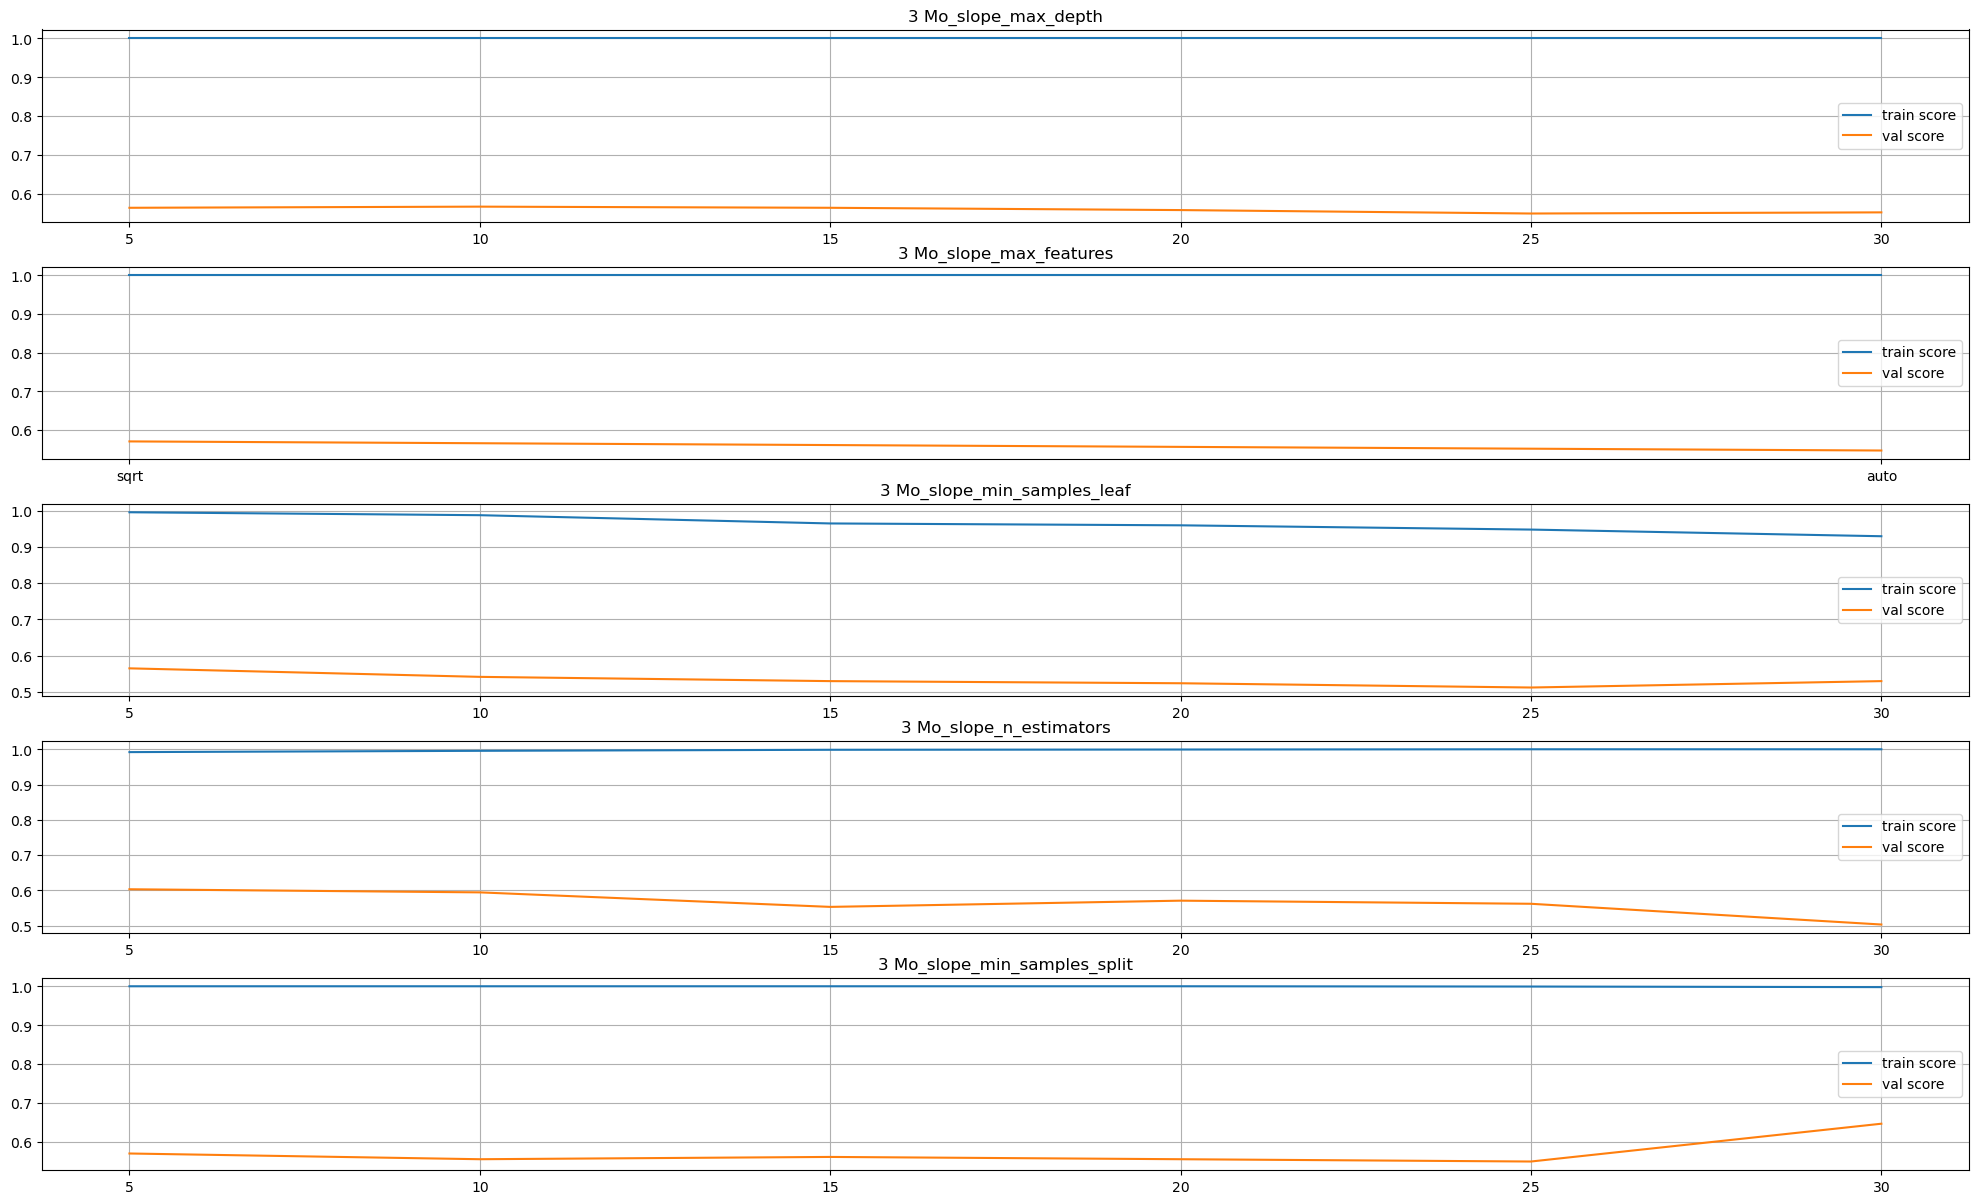

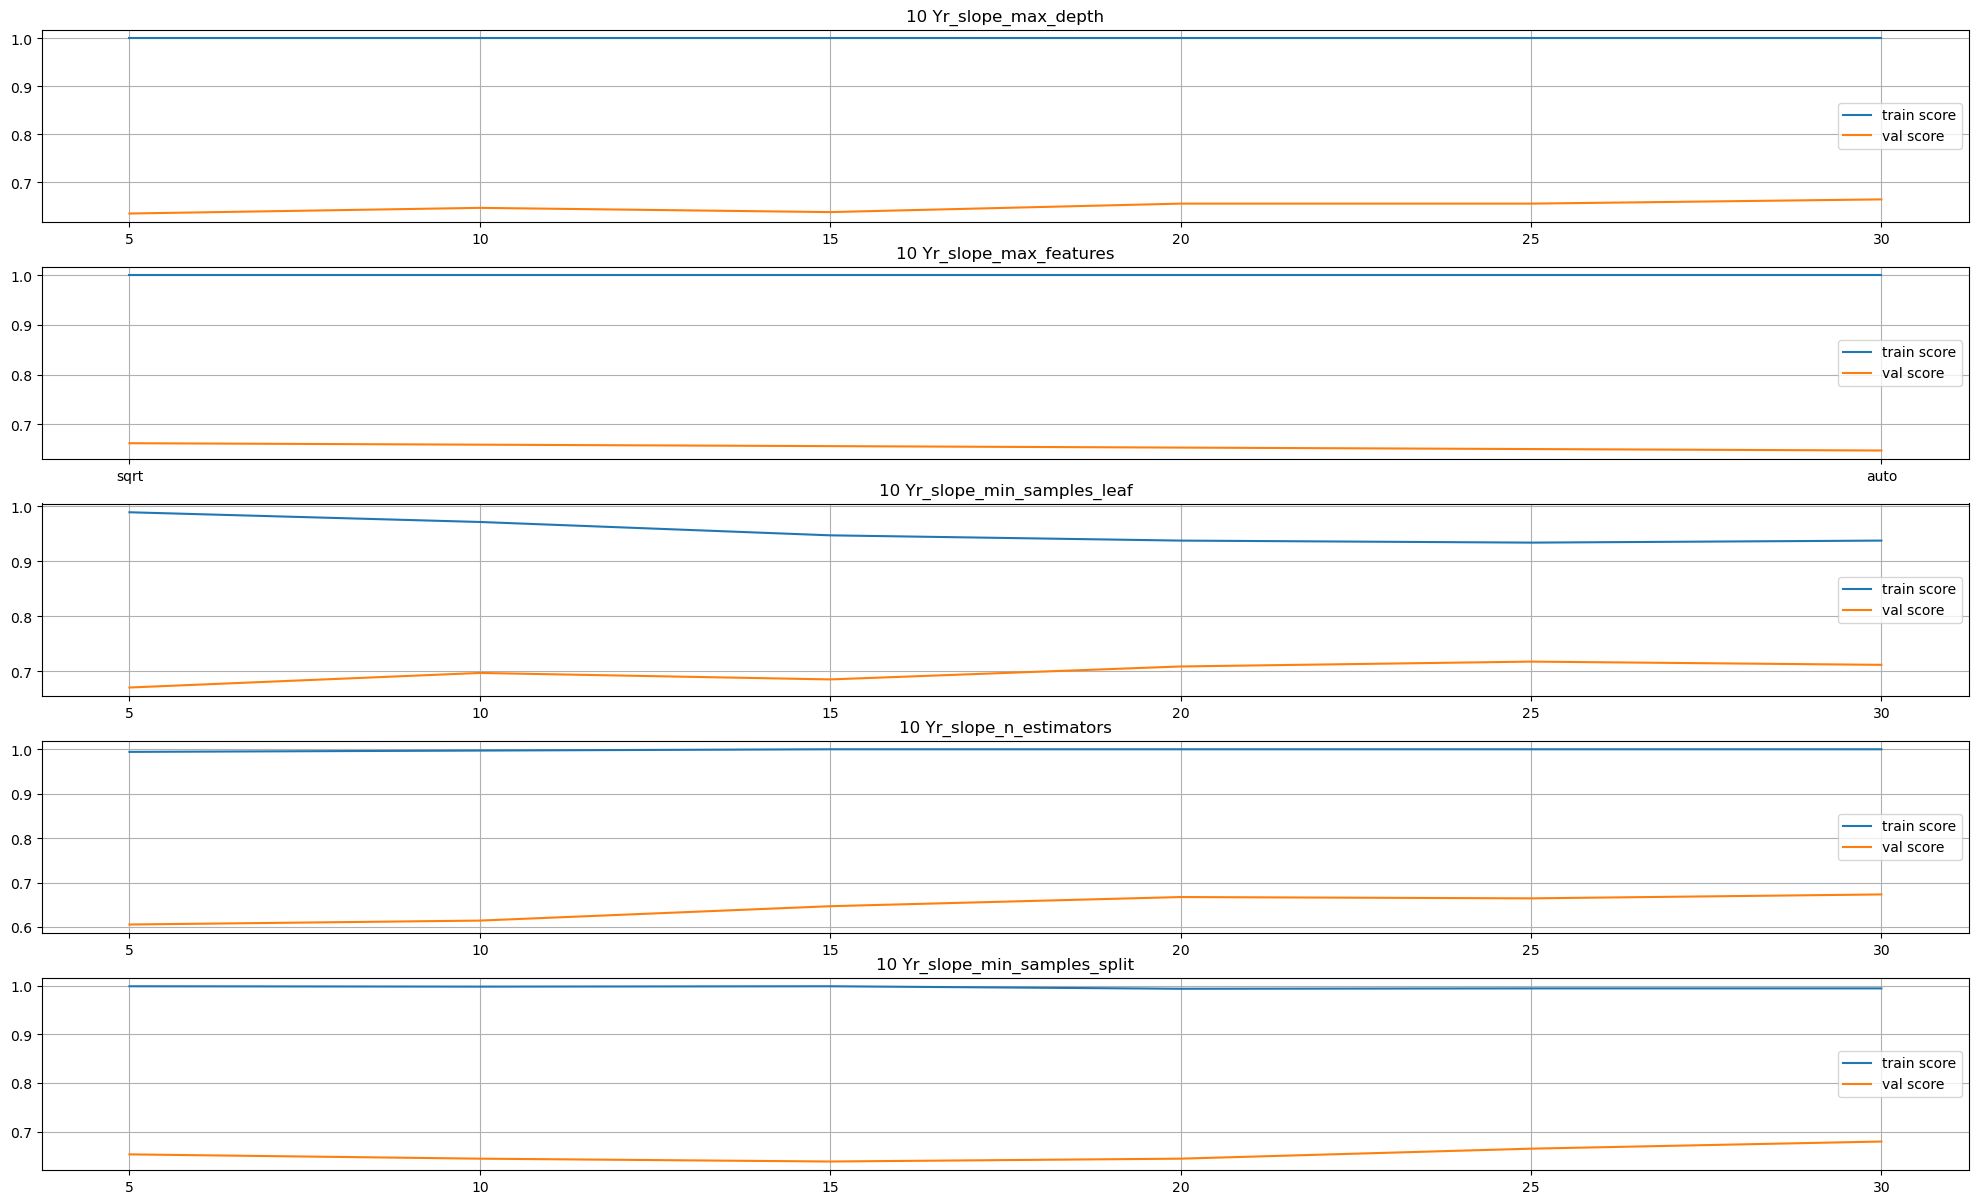

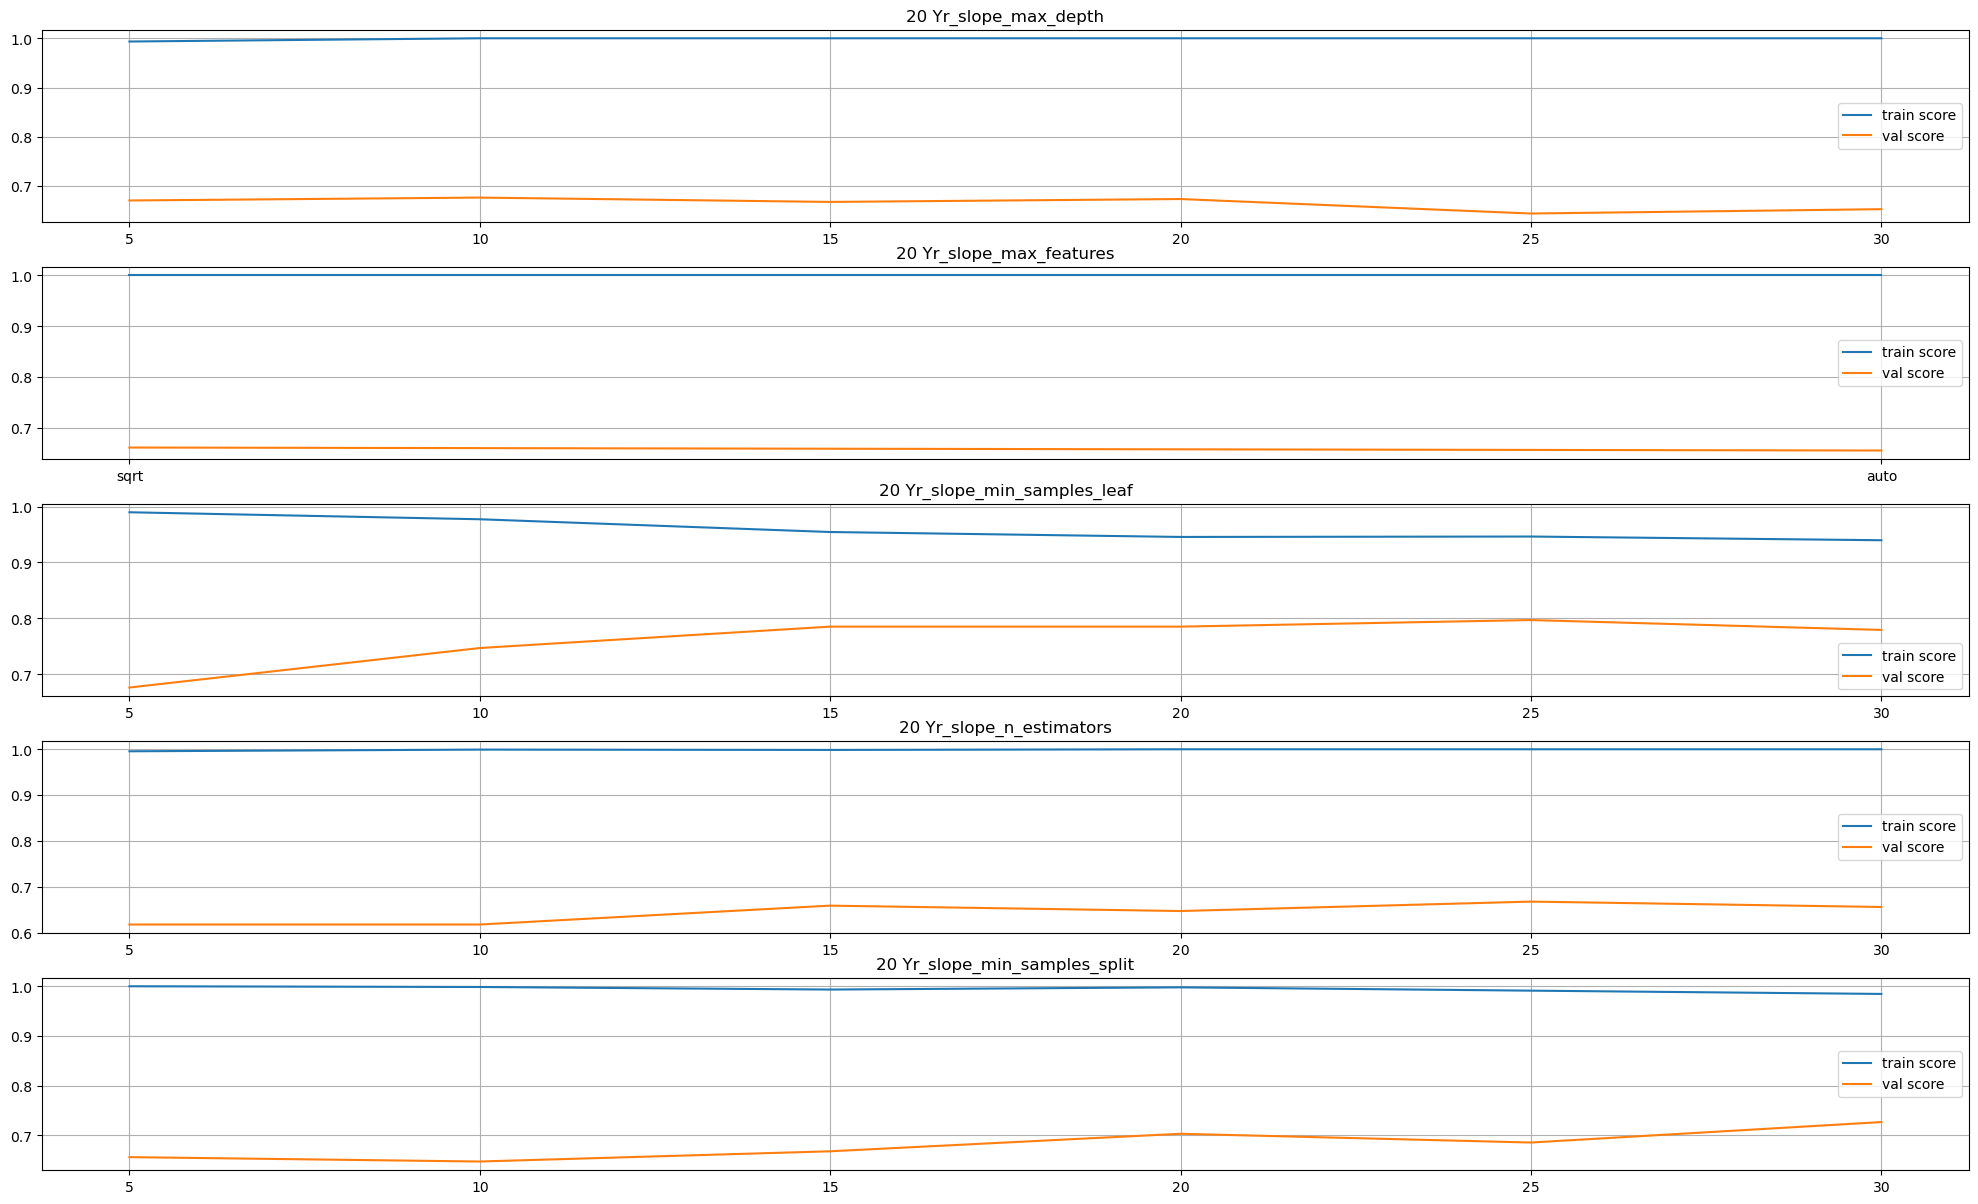

In [84]:
for slope in term_spreads:
    plot_validation_curve(train, 0, slope)

In [85]:
# Train 3M QE model
temp = train.loc[train['fed regime']==0, :].dropna()
trainx, trainy = temp.loc[:, lagged_indicators], temp.loc[:, ['3 Mo_slope_signal']]

params = {'max_depth': [i for i in range(5, 15)],
  'max_features': ['sqrt'],
  'min_samples_leaf': [i for i in range(4, 6)],
  'n_estimators': [i for i in range(5, 10)],
 'min_samples_split':[i for i in range(30, 35)]} 

rf = RandomForestClassifier()

# Cross validation using TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=3)

rf_cv = GridSearchCV(rf, params, cv=time_series_split, n_jobs=-1, verbose=20)

#Fit the random forest with our X_train and Y_train
rf_cv.fit(trainx, trainy)

#Save the fited variable into a Pickle file
file_loc = 'UST_RF_model_3 Mo_slope_QE.pkl'
with open(file_loc, 'wb') as f:
    pickle.dump(rf_cv, f)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [86]:
# Train 10Y QE model
temp = train.loc[train['fed regime']==0, :].dropna()
trainx, trainy = temp.loc[:, lagged_indicators], temp.loc[:, ['10 Yr_slope_signal']]

params = {'max_depth': [i for i in range(30, 35)],
  'max_features': ['sqrt'],
  'min_samples_leaf': [i for i in range(25, 30)],
  'n_estimators': [i for i in range(30, 35)],
 'min_samples_split':[i for i in range(30, 35)]} 

rf = RandomForestClassifier()

# Cross validation using TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=3)

rf_cv = GridSearchCV(rf, params, cv=time_series_split, n_jobs=-1, verbose=20)

#Fit the random forest with our X_train and Y_train
rf_cv.fit(trainx, trainy)

#Save the fited variable into a Pickle file
file_loc = 'UST_RF_model_10 Yr_slope_QE.pkl'
with open(file_loc, 'wb') as f:
    pickle.dump(rf_cv, f)

Fitting 3 folds for each of 625 candidates, totalling 1875 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [88]:
# Train 20Y QE model
temp = train.loc[train['fed regime']==0, :].dropna()
trainx, trainy = temp.loc[:, lagged_indicators], temp.loc[:, ['20 Yr_slope_signal']]

params = {'max_depth': [i for i in range(15, 20)],
  'max_features': ['sqrt'],
  'min_samples_leaf': [i for i in range(24, 26)],
  'n_estimators': [i for i in range(14, 16)],
 'min_samples_split':[i for i in range(30, 35)]} 

rf = RandomForestClassifier()

# Cross validation using TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=3)

rf_cv = GridSearchCV(rf, params, cv=time_series_split, n_jobs=-1, verbose=20)

#Fit the random forest with our X_train and Y_train
rf_cv.fit(trainx, trainy)

#Save the fited variable into a Pickle file
file_loc = 'UST_RF_model_20 Yr_slope_QE.pkl'
with open(file_loc, 'wb') as f:
    pickle.dump(rf_cv, f)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


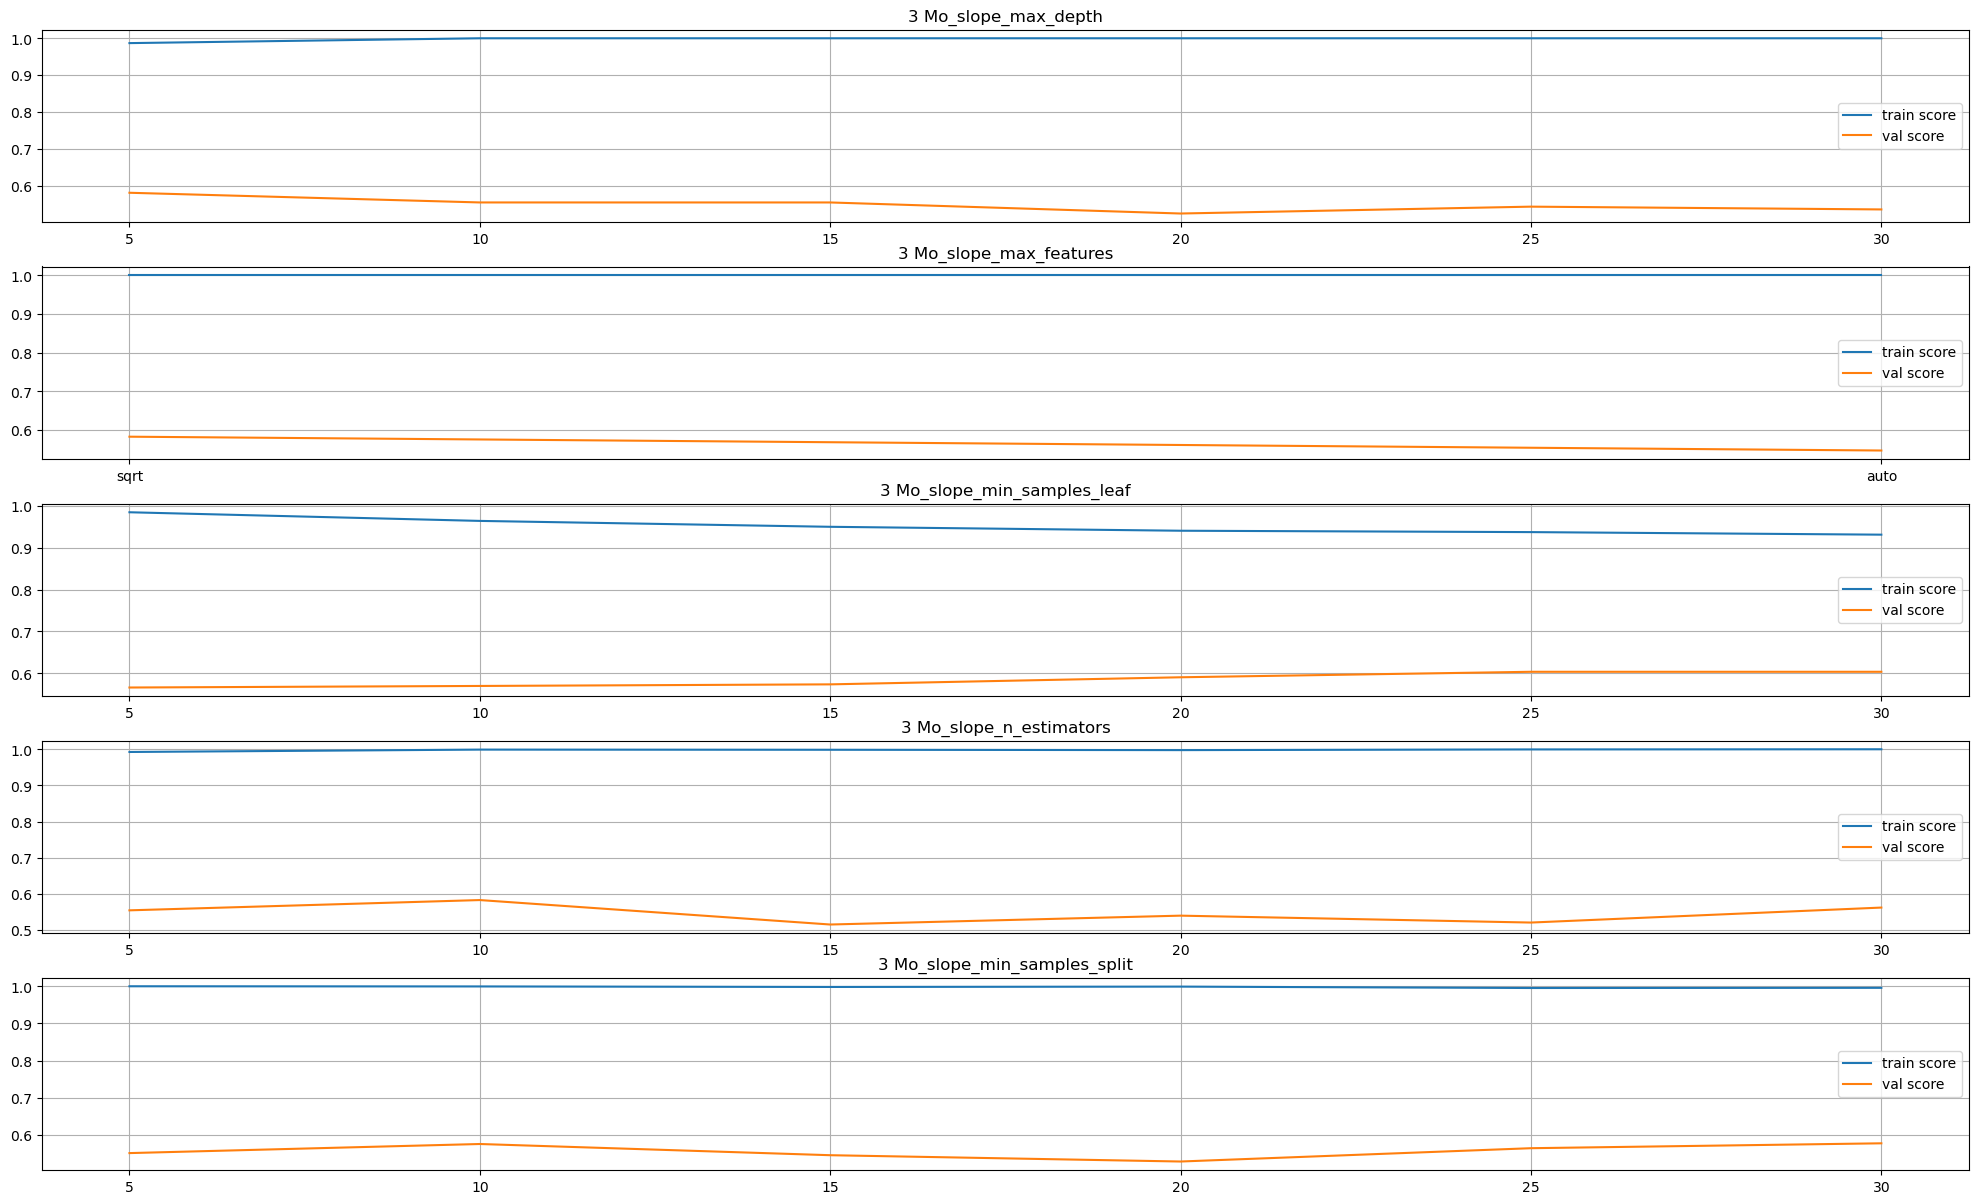

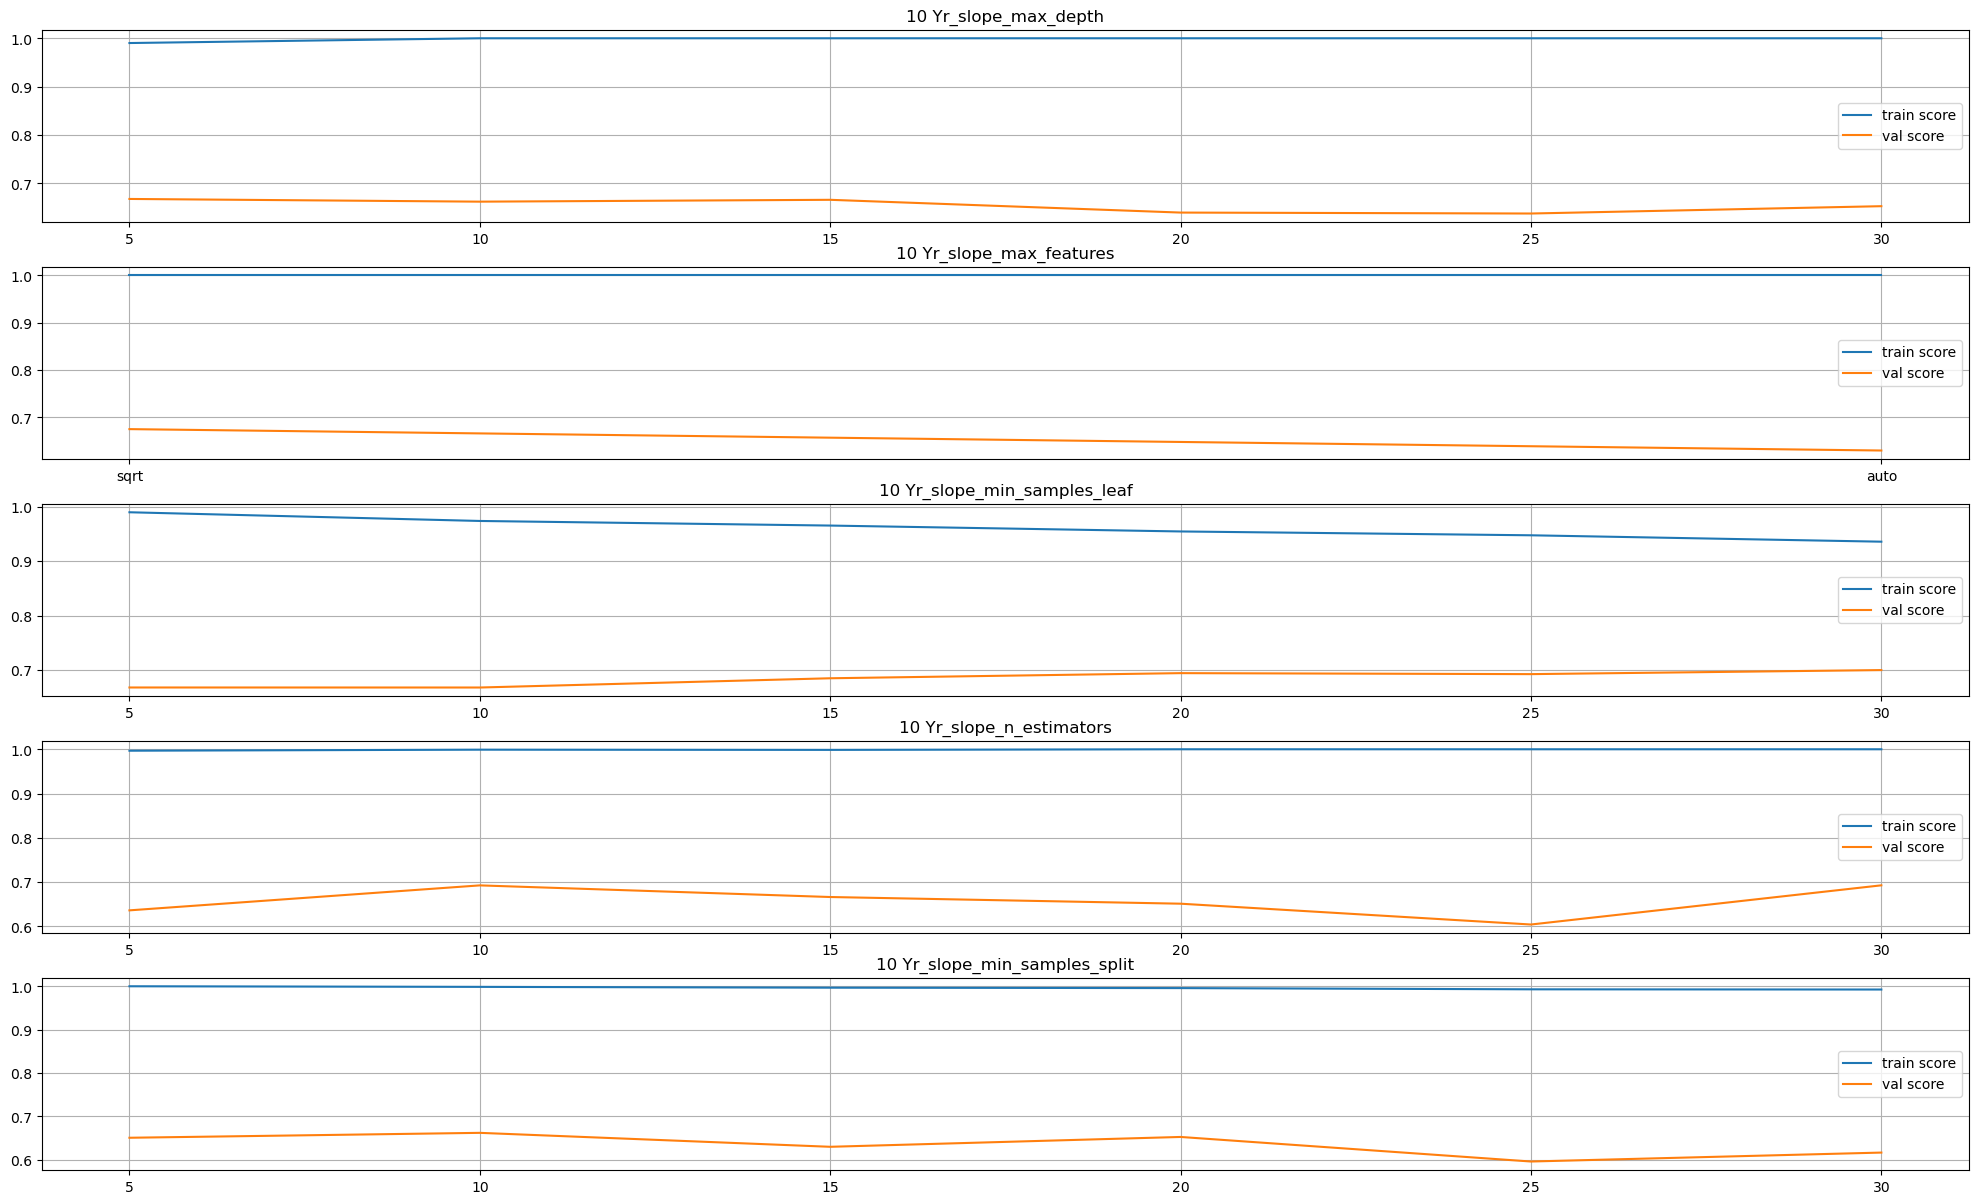

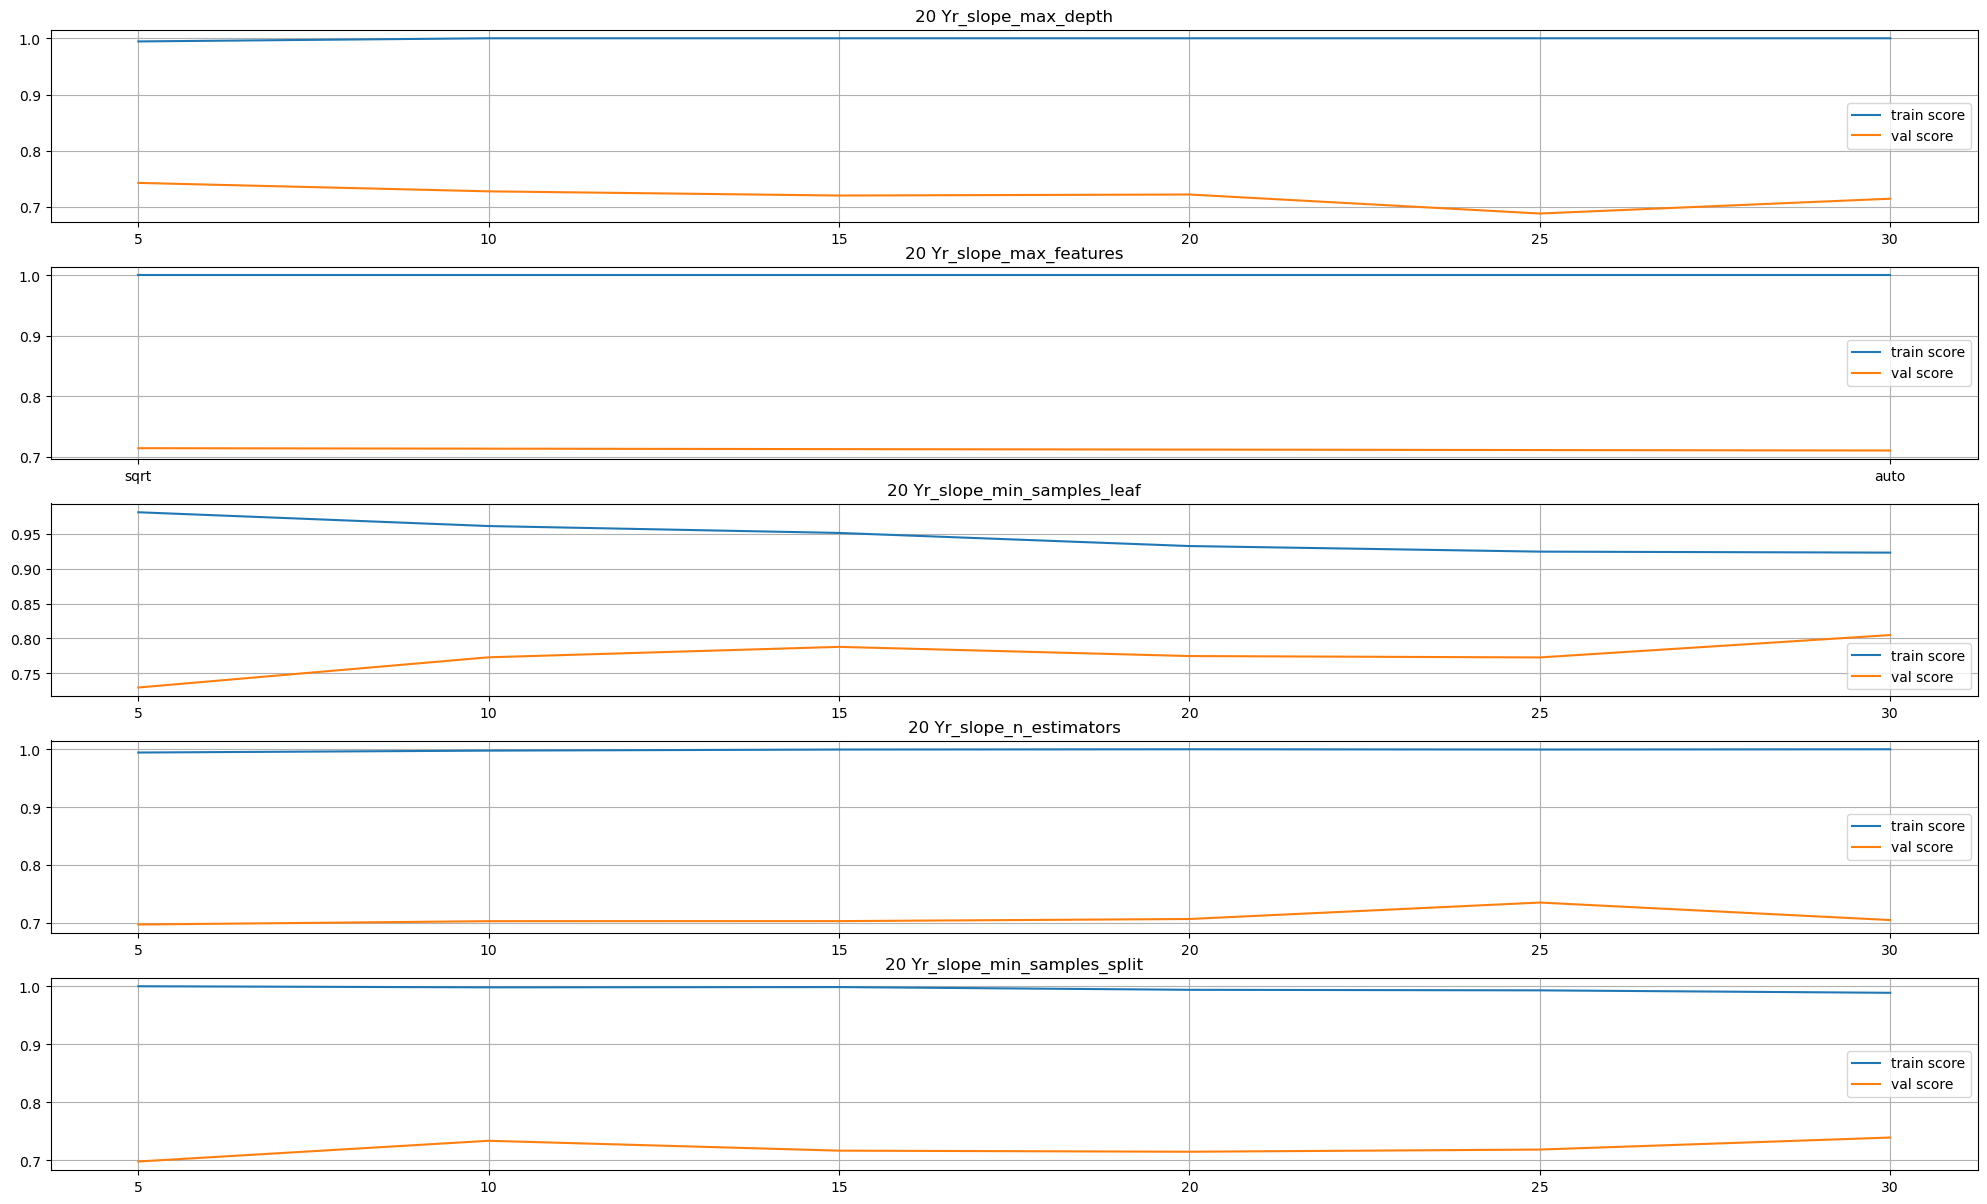

In [89]:
for slope in term_spreads:
    plot_validation_curve(train, 1, slope)

In [90]:
# Train 3M QT model
temp = train.loc[train['fed regime']==1, :].dropna()
trainx, trainy = temp.loc[:, lagged_indicators], temp.loc[:, ['3 Mo_slope_signal']]

params = {'max_depth': [i for i in range(4, 6)],
  'max_features': ['sqrt'],
  'min_samples_leaf': [i for i in range(25, 30)],
  'n_estimators': [i for i in range(9, 11)],
 'min_samples_split':[i for i in range(9, 11)]} 

rf = RandomForestClassifier()

# Cross validation using TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=3)

rf_cv = GridSearchCV(rf, params, cv=time_series_split, n_jobs=-1, verbose=20)

#Fit the random forest with our X_train and Y_train
rf_cv.fit(trainx, trainy)

#Save the fited variable into a Pickle file
file_loc = 'UST_RF_model_3 Mo_slope_QT.pkl'
with open(file_loc, 'wb') as f:
    pickle.dump(rf_cv, f)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [91]:
# Train 10Y QT model
temp = train.loc[train['fed regime']==1, :].dropna()
trainx, trainy = temp.loc[:, lagged_indicators], temp.loc[:, ['10 Yr_slope_signal']]

params = {'max_depth': [i for i in range(5, 10)],
  'max_features': ['sqrt'],
  'min_samples_leaf': [i for i in range(30, 35)],
  'n_estimators': [i for i in range(30, 35)],
 'min_samples_split':[i for i in range(5, 10)]} 

rf = RandomForestClassifier()

# Cross validation using TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=3)

rf_cv = GridSearchCV(rf, params, cv=time_series_split, n_jobs=-1, verbose=20)

#Fit the random forest with our X_train and Y_train
rf_cv.fit(trainx, trainy)

#Save the fited variable into a Pickle file
file_loc = 'UST_RF_model_10 Yr_slope_QT.pkl'
with open(file_loc, 'wb') as f:
    pickle.dump(rf_cv, f)

Fitting 3 folds for each of 625 candidates, totalling 1875 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [92]:
# Train 20Y QT model
temp = train.loc[train['fed regime']==1, :].dropna()
trainx, trainy = temp.loc[:, lagged_indicators], temp.loc[:, ['20 Yr_slope_signal']]

params = {'max_depth': [i for i in range(4, 6)],
  'max_features': ['sqrt'],
  'min_samples_leaf': [i for i in range(30, 35)],
  'n_estimators': [i for i in range(24, 26)],
 'min_samples_split':[i for i in range(30, 35)]} 

rf = RandomForestClassifier()

# Cross validation using TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=3)

rf_cv = GridSearchCV(rf, params, cv=time_series_split, n_jobs=-1, verbose=20)

#Fit the random forest with our X_train and Y_train
rf_cv.fit(trainx, trainy)

#Save the fited variable into a Pickle file
file_loc = 'UST_RF_model_20 Yr_slope_QT.pkl'
with open(file_loc, 'wb') as f:
    pickle.dump(rf_cv, f)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


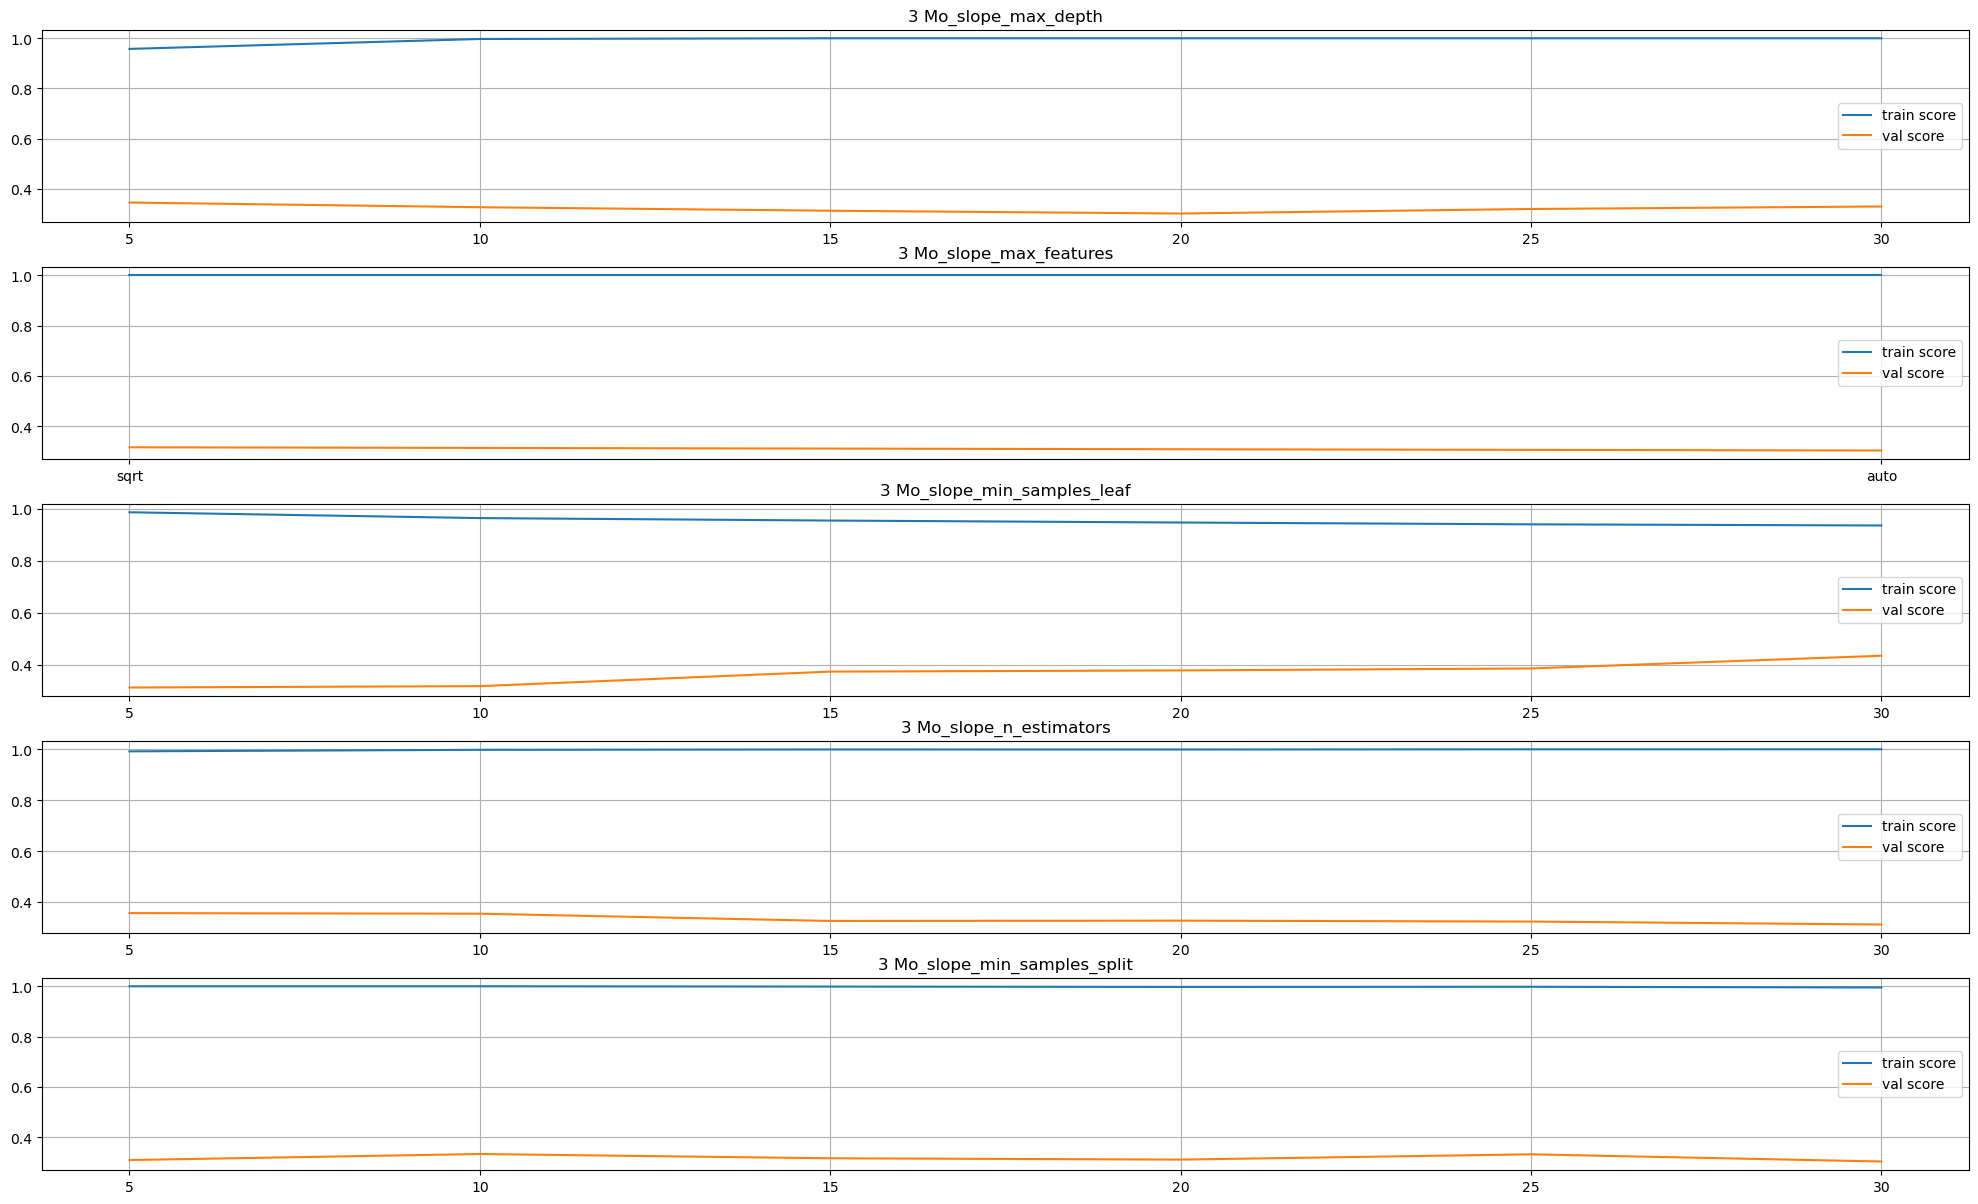

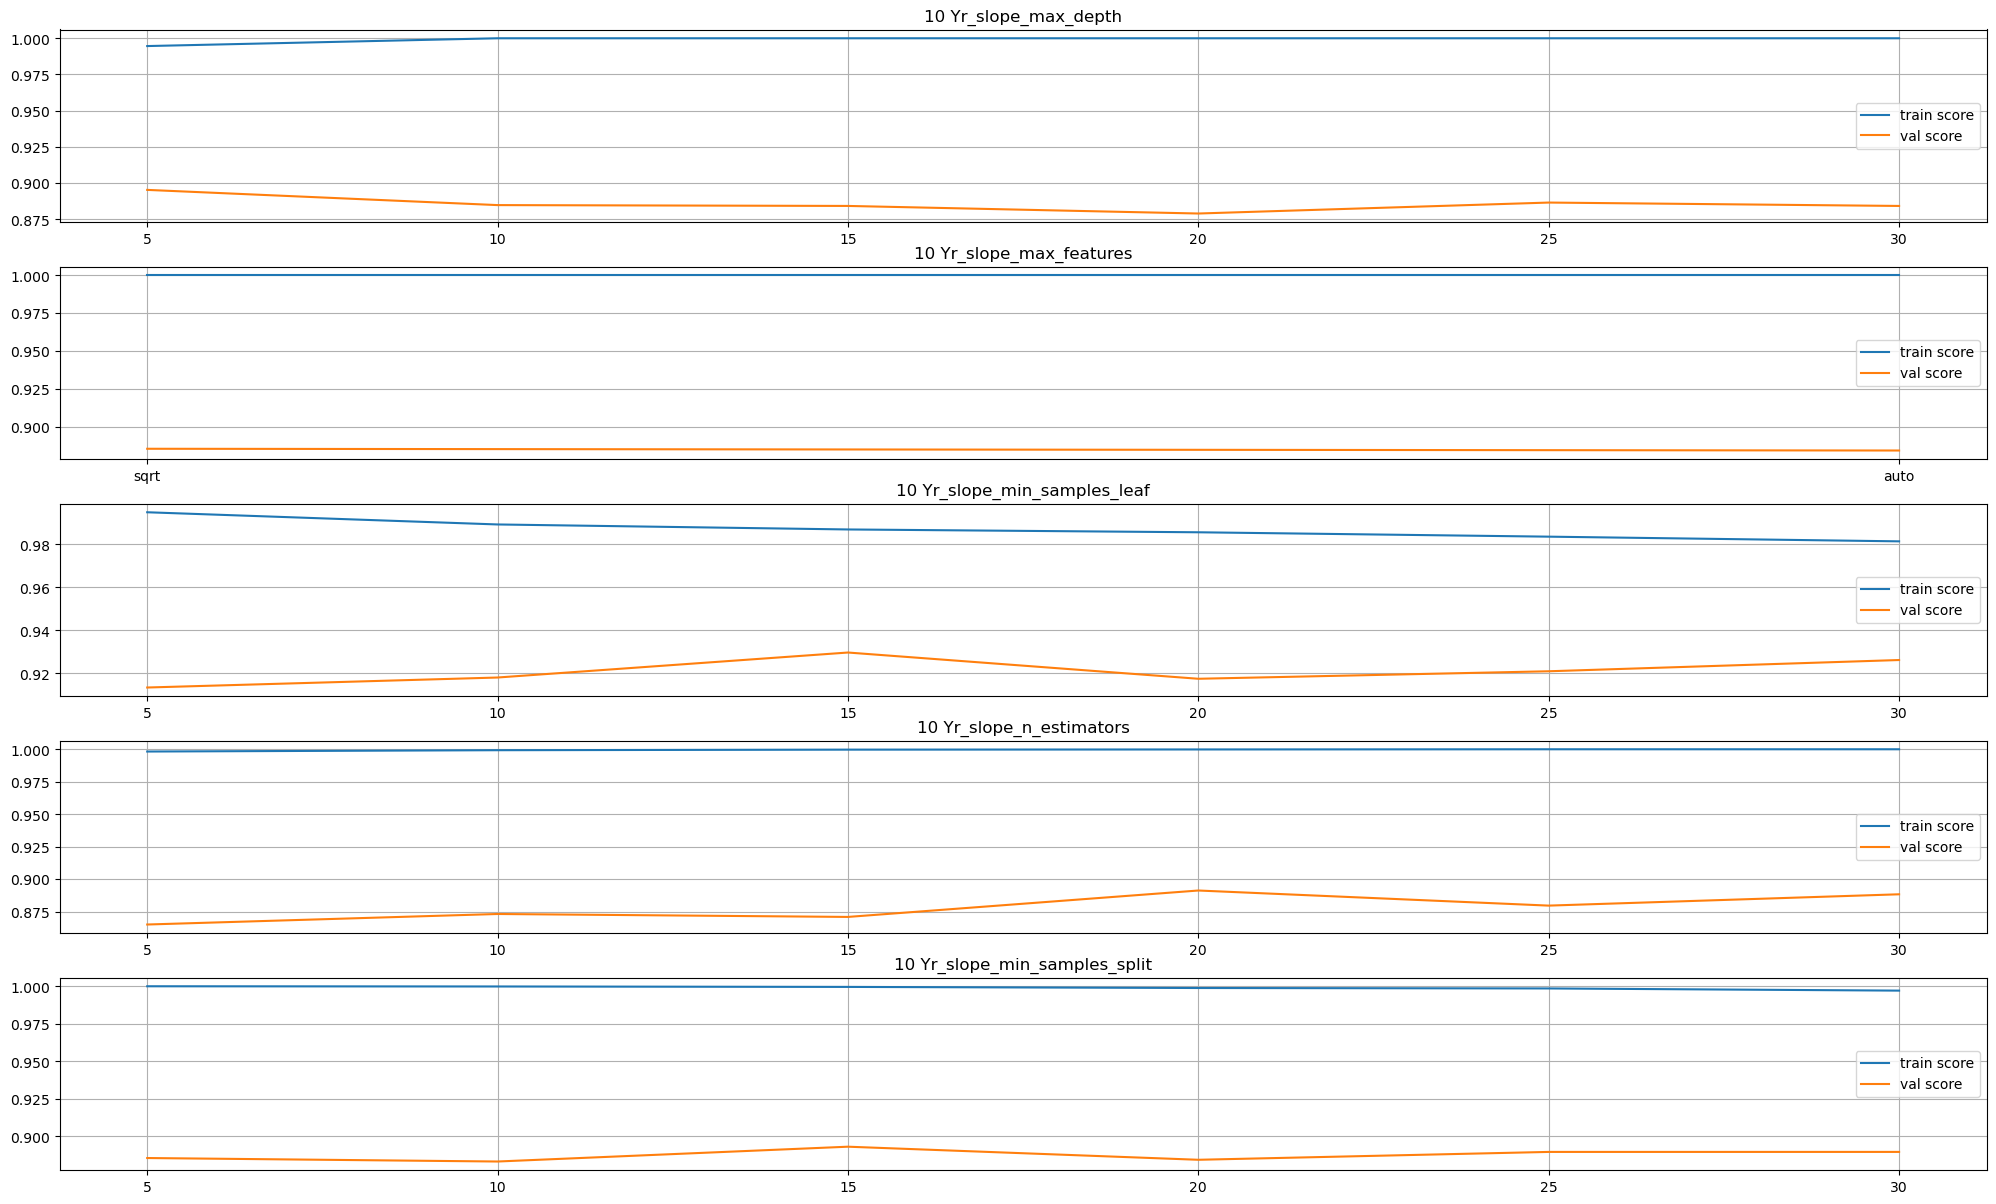

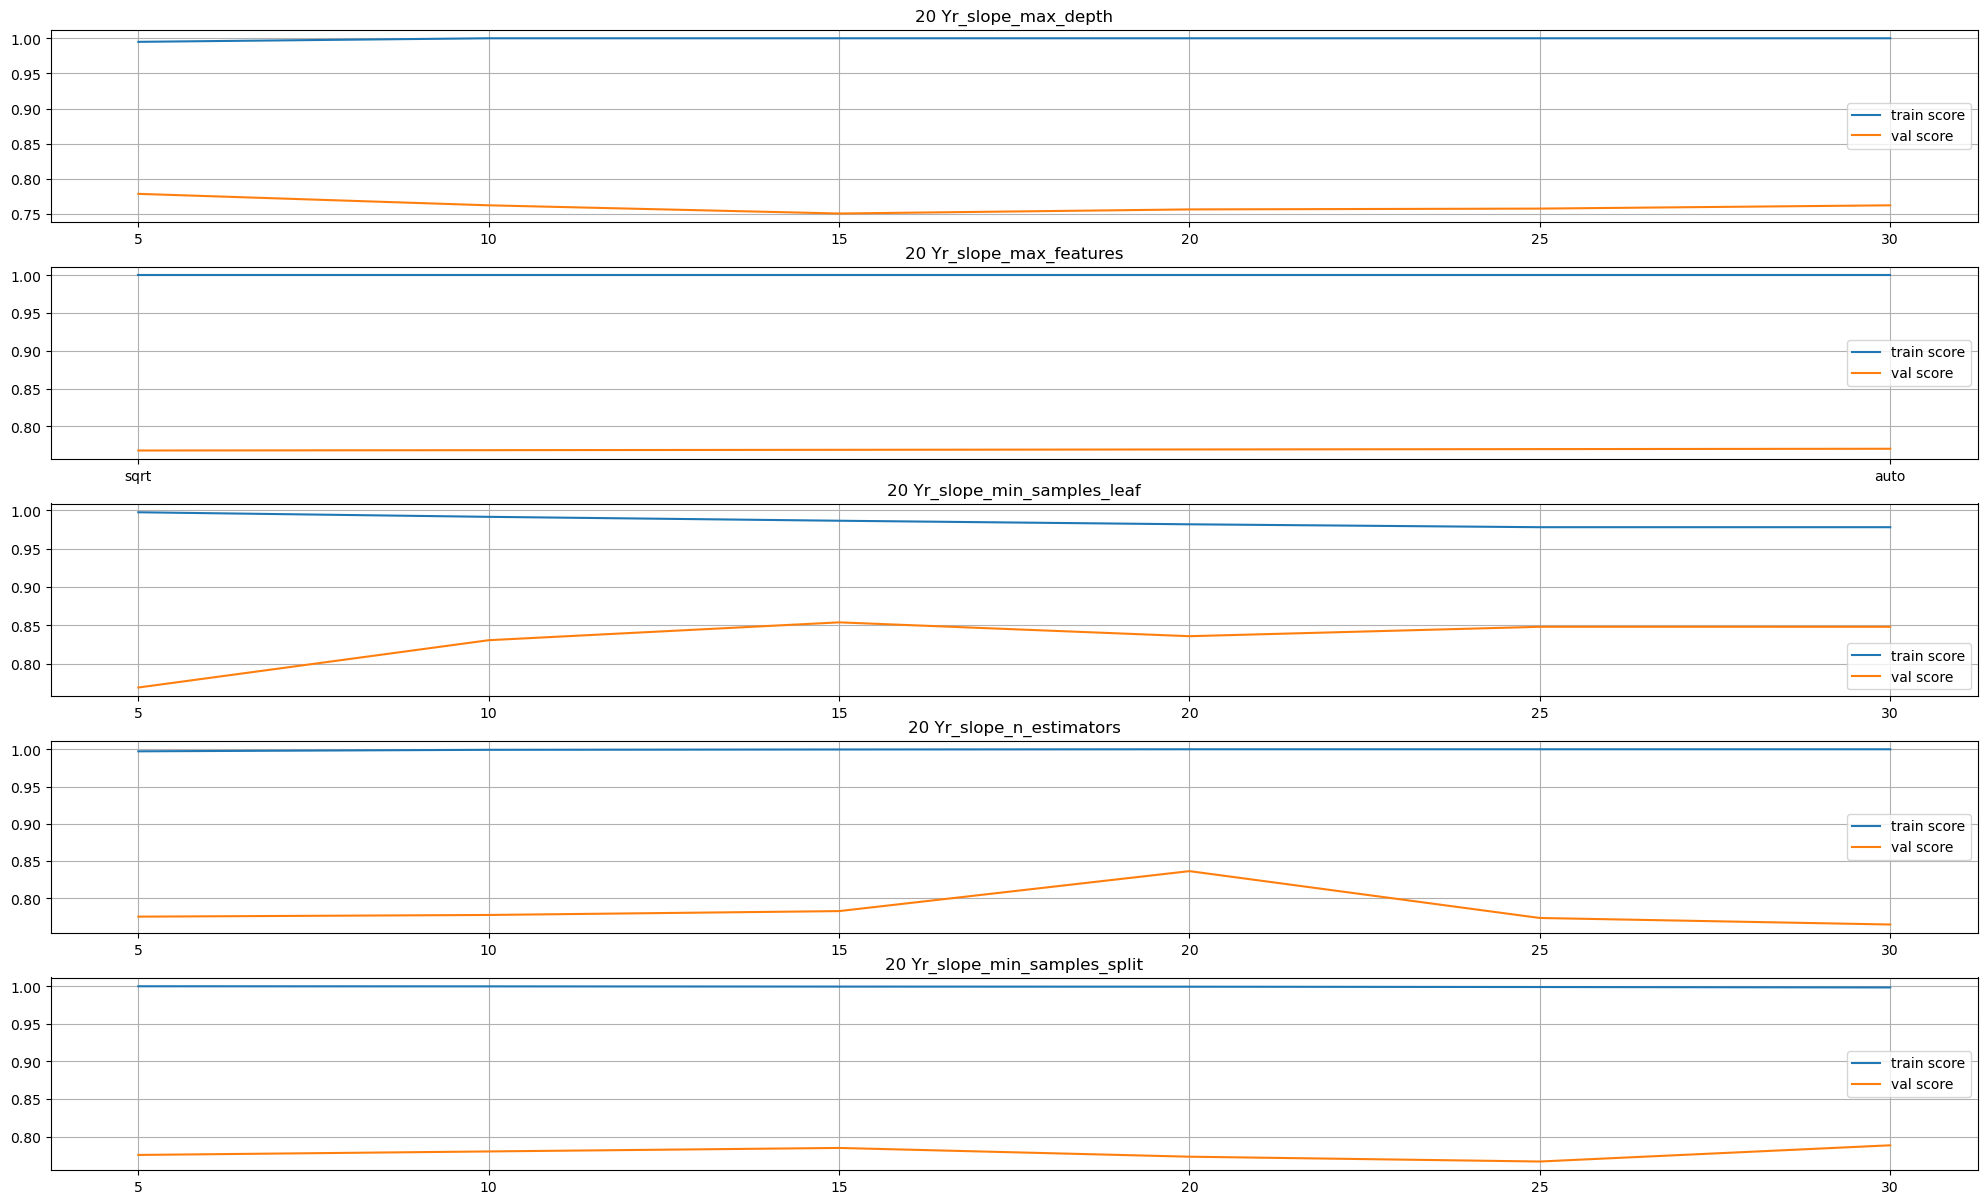

In [93]:
for slope in term_spreads:
    plot_validation_curve(train, 2, slope)

In [94]:
# Train 3M constant low rates model
temp = train.loc[train['fed regime']==2, :].dropna()
trainx, trainy = temp.loc[:, lagged_indicators], temp.loc[:, ['3 Mo_slope_signal']]

params = {'max_depth': [i for i in range(4, 6)],
  'max_features': ['sqrt'],
  'min_samples_leaf': [i for i in range(30, 35)],
  'n_estimators': [i for i in range(5, 10)],
 'min_samples_split':[i for i in range(24, 26)]} 

rf = RandomForestClassifier()

# Cross validation using TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=3)

rf_cv = GridSearchCV(rf, params, cv=time_series_split, n_jobs=-1, verbose=20)

#Fit the random forest with our X_train and Y_train
rf_cv.fit(trainx, trainy)

#Save the fited variable into a Pickle file
file_loc = 'UST_RF_model_3 Mo_slope_low_rates.pkl'
with open(file_loc, 'wb') as f:
    pickle.dump(rf_cv, f)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [95]:
# Train 10Y constant low rates model
temp = train.loc[train['fed regime']==2, :]
temp = temp.iloc[:-period, :]
trainx, trainy = temp.loc[:, lagged_indicators], temp.loc[:, ['10 Yr_slope_signal']]

params = {'max_depth': [i for i in range(4, 6)],
  'max_features': ['sqrt', 'auto'],
  'min_samples_leaf': [i for i in range(14, 16)],
  'n_estimators': [i for i in range(19, 21)],
 'min_samples_split':[i for i in range(14, 16)]} 

rf = RandomForestClassifier()

# Cross validation using TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=3)

rf_cv = GridSearchCV(rf, params, cv=time_series_split, n_jobs=-1, verbose=20)

#Fit the random forest with our X_train and Y_train
rf_cv.fit(trainx, trainy)

#Save the fited variable into a Pickle file
file_loc = 'UST_RF_model_10 Yr_slope_low_rates.pkl'
with open(file_loc, 'wb') as f:
    pickle.dump(rf_cv, f)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [96]:
# Train 20Y constant low rates model
temp = train.loc[train['fed regime']==2, :]
temp = temp.iloc[:-period, :]
trainx, trainy = temp.loc[:, lagged_indicators], temp.loc[:, ['20 Yr_slope_signal']]

params = {'max_depth': [i for i in range(4, 6)],
  'max_features': ['sqrt', 'auto'],
  'min_samples_leaf': [i for i in range(14, 16)],
  'n_estimators': [i for i in range(19, 21)],
 'min_samples_split':[i for i in range(30, 35)]} 

rf = RandomForestClassifier()

# Cross validation using TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=3)

rf_cv = GridSearchCV(rf, params, cv=time_series_split, n_jobs=-1, verbose=20)

#Fit the random forest with our X_train and Y_train
rf_cv.fit(trainx, trainy)

#Save the fited variable into a Pickle file
file_loc = 'UST_RF_model_20 Yr_slope_low_rates.pkl'
with open(file_loc, 'wb') as f:
    pickle.dump(rf_cv, f)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [97]:
positions_3M = []
positions_10Y = []
positions_20Y = []

for i in range(len(test.index)):
    temp = test.loc[test.index == test.index[i], :]
    tempx = temp.loc[:, lagged_indicators]
    if i%period == 0:
        if temp.iloc[0]['fed regime'] == 0:
            regime = 'QE'
        elif temp.iloc[0]['fed regime'] == 1:
            regime = 'QT'
        else:
            regime = 'low_rates'
            
        with open(f'UST_RF_model_3 Mo_slope_{regime}.pkl', 'rb') as f:
            model_3M = pickle.load(f).best_estimator_
        with open(f'UST_RF_model_10 Yr_slope_{regime}.pkl', 'rb') as f:
            model_10Y = pickle.load(f).best_estimator_
        with open(f'UST_RF_model_20 Yr_slope_{regime}.pkl', 'rb') as f:
            model_20Y = pickle.load(f).best_estimator_
            
        positions_3M.append(-1 if np.argmax(model_3M.predict_proba) == 0 else 1)
        positions_10Y.append(-1 if np.argmax(model_10Y.predict_proba) == 0 else 1)
        positions_20Y.append(-1 if np.argmax(model_20Y.predict_proba) == 0 else 1)
    
    else:
        positions_3M.append(0)
        positions_10Y.append(0)
        positions_20Y.append(0)

In [98]:
def strategy_return(test_df, pos_3M, pos_10Y, pos_20Y):
    temp = test_df.loc[:, [f'{slope}_signal' for slope in term_spreads] + [f'{tenure} MTM PnL' for tenure in [tenures[i] for i in [1, 8, 9]]]]
    temp.loc[:, f'3 Mo_position'] = pos_3M
    temp.loc[:, f'10 Yr_position'] = pos_10Y
    temp.loc[:, f'20 Yr_position'] = pos_20Y
    for i in range(len(test_df)):
        date = temp.index[i]
        for tenure in [tenures[j] for j in [1, 8, 9]]:
            if i%period == 0:
                temp.loc[temp.index==date, f'{tenure}_return'] = temp.loc[temp.index==date, f'{tenure} MTM PnL']*temp.loc[temp.index==date, f'{tenure}_position']
            else:
                temp.loc[temp.index==date, f'{tenure}_return'] = 0
    temp.loc[:, 'avg return'] = (temp.loc[:, [f'{tenure}_return' for tenure in [tenures[i] for i in [1, 8, 9]]]].mean(axis=1) + 1).shift(period).fillna(1)
    temp.loc[:, 'strategy'] = np.log(temp['avg return'])
    temp.loc[:, 'cumstrategy'] = temp.strategy.cumsum().apply(np.exp)
    return temp

In [99]:
test = test.loc[:, lagged_indicators + [f'{slope}_signal' for slope in term_spreads] + ['fed regime'] + [f'{tenure} MTM PnL' for tenure in [tenures[i] for i in [1, 8, 9]]]]
test

,1 Mo,1 Mo_1,1 Mo_2,1 Mo_3,1 Mo_4,1 Mo_5,1 Mo_6,1 Mo_7,1 Mo_8,1 Mo_9,...,20 Yr_slope_diff_97,20 Yr_slope_diff_98,20 Yr_slope_diff_99,3 Mo_slope_signal,10 Yr_slope_signal,20 Yr_slope_signal,fed regime,3 Mo MTM PnL,10 Yr MTM PnL,20 Yr MTM PnL
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.170,0.125,0.074,0.125,0.114,0.145,0.186,0.135,0.114,0.150,...,-0.435398,-0.478999,-0.487779,-1,1,1,1.0,-0.000211,0.045336,0.092256
2016-01-05,0.201,0.170,0.125,0.074,0.125,0.114,0.145,0.186,0.135,0.114,...,-0.482638,-0.435398,-0.478999,-1,1,1,1.0,-0.000183,0.044379,0.089735
2016-01-06,0.210,0.201,0.170,0.125,0.074,0.125,0.114,0.145,0.186,0.135,...,-0.491186,-0.482638,-0.435398,-1,1,1,1.0,-0.000162,0.041525,0.083346
2016-01-07,0.195,0.210,0.201,0.170,0.125,0.074,0.125,0.114,0.145,0.186,...,-0.476408,-0.491186,-0.482638,-1,1,1,1.0,-0.000237,0.037293,0.080581
2016-01-08,0.195,0.195,0.210,0.201,0.170,0.125,0.074,0.125,0.114,0.145,...,-0.461508,-0.476408,-0.491186,-1,1,1,1.0,-0.000277,0.044933,0.093426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12,3.728,3.677,3.514,3.603,3.721,3.761,3.743,3.840,3.947,3.986,...,0.221779,0.173009,0.132772,1,-1,-1,1.0,NaN,NaN,NaN
2022-12-13,3.778,3.728,3.677,3.514,3.603,3.721,3.761,3.743,3.840,3.947,...,0.235304,0.221779,0.173009,1,-1,-1,1.0,NaN,NaN,NaN
2022-12-14,3.772,3.778,3.728,3.677,3.514,3.603,3.721,3.761,3.743,3.840,...,0.214444,0.235304,0.221779,1,-1,-1,1.0,NaN,NaN,NaN


In [100]:
strategies = strategy_return(test, positions_3M, positions_10Y, positions_20Y)
strategies

,3 Mo_slope_signal,10 Yr_slope_signal,20 Yr_slope_signal,3 Mo MTM PnL,10 Yr MTM PnL,20 Yr MTM PnL,3 Mo_position,10 Yr_position,20 Yr_position,3 Mo_return,10 Yr_return,20 Yr_return,avg return,strategy,cumstrategy
Date,,,,,,,,,,,,,,,
2016-01-04,-1,1,1,-0.000211,0.045336,0.092256,-1,-1,-1,0.000211,-0.045336,-0.092256,1.0,0.0,1.000000
2016-01-05,-1,1,1,-0.000183,0.044379,0.089735,0,0,0,0.000000,0.000000,0.000000,1.0,0.0,1.000000
2016-01-06,-1,1,1,-0.000162,0.041525,0.083346,0,0,0,0.000000,0.000000,0.000000,1.0,0.0,1.000000
2016-01-07,-1,1,1,-0.000237,0.037293,0.080581,0,0,0,0.000000,0.000000,0.000000,1.0,0.0,1.000000
2016-01-08,-1,1,1,-0.000277,0.044933,0.093426,0,0,0,0.000000,0.000000,0.000000,1.0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12,1,-1,-1,NaN,NaN,NaN,0,0,0,0.000000,0.000000,0.000000,1.0,0.0,1.082598
2022-12-13,1,-1,-1,NaN,NaN,NaN,0,0,0,0.000000,0.000000,0.000000,1.0,0.0,1.082598
2022-12-14,1,-1,-1,NaN,NaN,NaN,0,0,0,0.000000,0.000000,0.000000,1.0,0.0,1.082598


In [101]:
strategies.loc[strategies.index < '2021-01-01', :]

,3 Mo_slope_signal,10 Yr_slope_signal,20 Yr_slope_signal,3 Mo MTM PnL,10 Yr MTM PnL,20 Yr MTM PnL,3 Mo_position,10 Yr_position,20 Yr_position,3 Mo_return,10 Yr_return,20 Yr_return,avg return,strategy,cumstrategy
Date,,,,,,,,,,,,,,,
2016-01-04,-1,1,1,-0.000211,0.045336,0.092256,-1,-1,-1,0.000211,-0.045336,-0.092256,1.0,0.0,1.000000
2016-01-05,-1,1,1,-0.000183,0.044379,0.089735,0,0,0,0.000000,0.000000,0.000000,1.0,0.0,1.000000
2016-01-06,-1,1,1,-0.000162,0.041525,0.083346,0,0,0,0.000000,0.000000,0.000000,1.0,0.0,1.000000
2016-01-07,-1,1,1,-0.000237,0.037293,0.080581,0,0,0,0.000000,0.000000,0.000000,1.0,0.0,1.000000
2016-01-08,-1,1,1,-0.000277,0.044933,0.093426,0,0,0,0.000000,0.000000,0.000000,1.0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,-1,-1,-1,0.000148,-0.024549,-0.067179,0,0,0,0.000000,0.000000,0.000000,1.0,0.0,0.852586
2020-12-28,-1,-1,-1,0.000124,-0.021539,-0.058559,0,0,0,0.000000,0.000000,0.000000,1.0,0.0,0.852586
2020-12-29,-1,-1,-1,0.000104,-0.023593,-0.065436,0,0,0,0.000000,0.000000,0.000000,1.0,0.0,0.852586


In [103]:
hits_3M = []
hits_10Y = []
hits_20Y = []

for i in range(len(strategies.loc[strategies.index < '2021-01-01', :].index)):
    if i%period==0:
        hits_3M.append(1 if strategies.loc[strategies.index < '2021-01-01', :].iloc[i]['3 Mo_position'] == strategies.loc[strategies.index < '2021-01-01', :].iloc[i]['3 Mo_slope_signal'] else 0)
        hits_10Y.append(1 if strategies.loc[strategies.index < '2021-01-01', :].iloc[i]['10 Yr_position'] == strategies.loc[strategies.index < '2021-01-01', :].iloc[i]['10 Yr_slope_signal'] else 0)
        hits_20Y.append(1 if strategies.loc[strategies.index < '2021-01-01', :].iloc[i]['20 Yr_position'] == strategies.loc[strategies.index < '2021-01-01', :].iloc[i]['20 Yr_slope_signal'] else 0)

print(np.mean(hits_3M)*100)
print(np.mean(hits_10Y)*100)
print(np.mean(hits_20Y)*100)
np.mean(np.array(hits_3M + hits_10Y + hits_20Y))*100

59.523809523809526
47.61904761904761
69.04761904761905


58.730158730158735

In [104]:
hits_3M = []
hits_10Y = []
hits_20Y = []

for i in range(len(strategies.index)):
    if i%period==0:
        hits_3M.append(1 if strategies.iloc[i]['3 Mo_position'] == strategies.iloc[i]['3 Mo_slope_signal'] else 0)
        hits_10Y.append(1 if strategies.iloc[i]['10 Yr_position'] == strategies.iloc[i]['10 Yr_slope_signal'] else 0)
        hits_20Y.append(1 if strategies.iloc[i]['20 Yr_position'] == strategies.iloc[i]['20 Yr_slope_signal'] else 0)

print(np.mean(hits_3M)*100)
print(np.mean(hits_10Y)*100)
print(np.mean(hits_20Y)*100)
np.mean(np.array(hits_3M + hits_10Y + hits_20Y))*100

56.896551724137936
62.06896551724138
70.6896551724138


63.2183908045977

In [105]:
def plot_returns(benchmark, strategy, title):
    plt.figure(figsize=(20, 12))
    plt.plot(pd.to_datetime(strategy.index).date, strategy.cumstrategy, label='Model')
    plt.plot(benchmark.index, benchmark['cumreturn'], color='red', label='iShares UST Bond ETF Buy & Hold')
    plt.title(title)
    plt.gca().grid(True)
    plt.legend(loc='upper left')

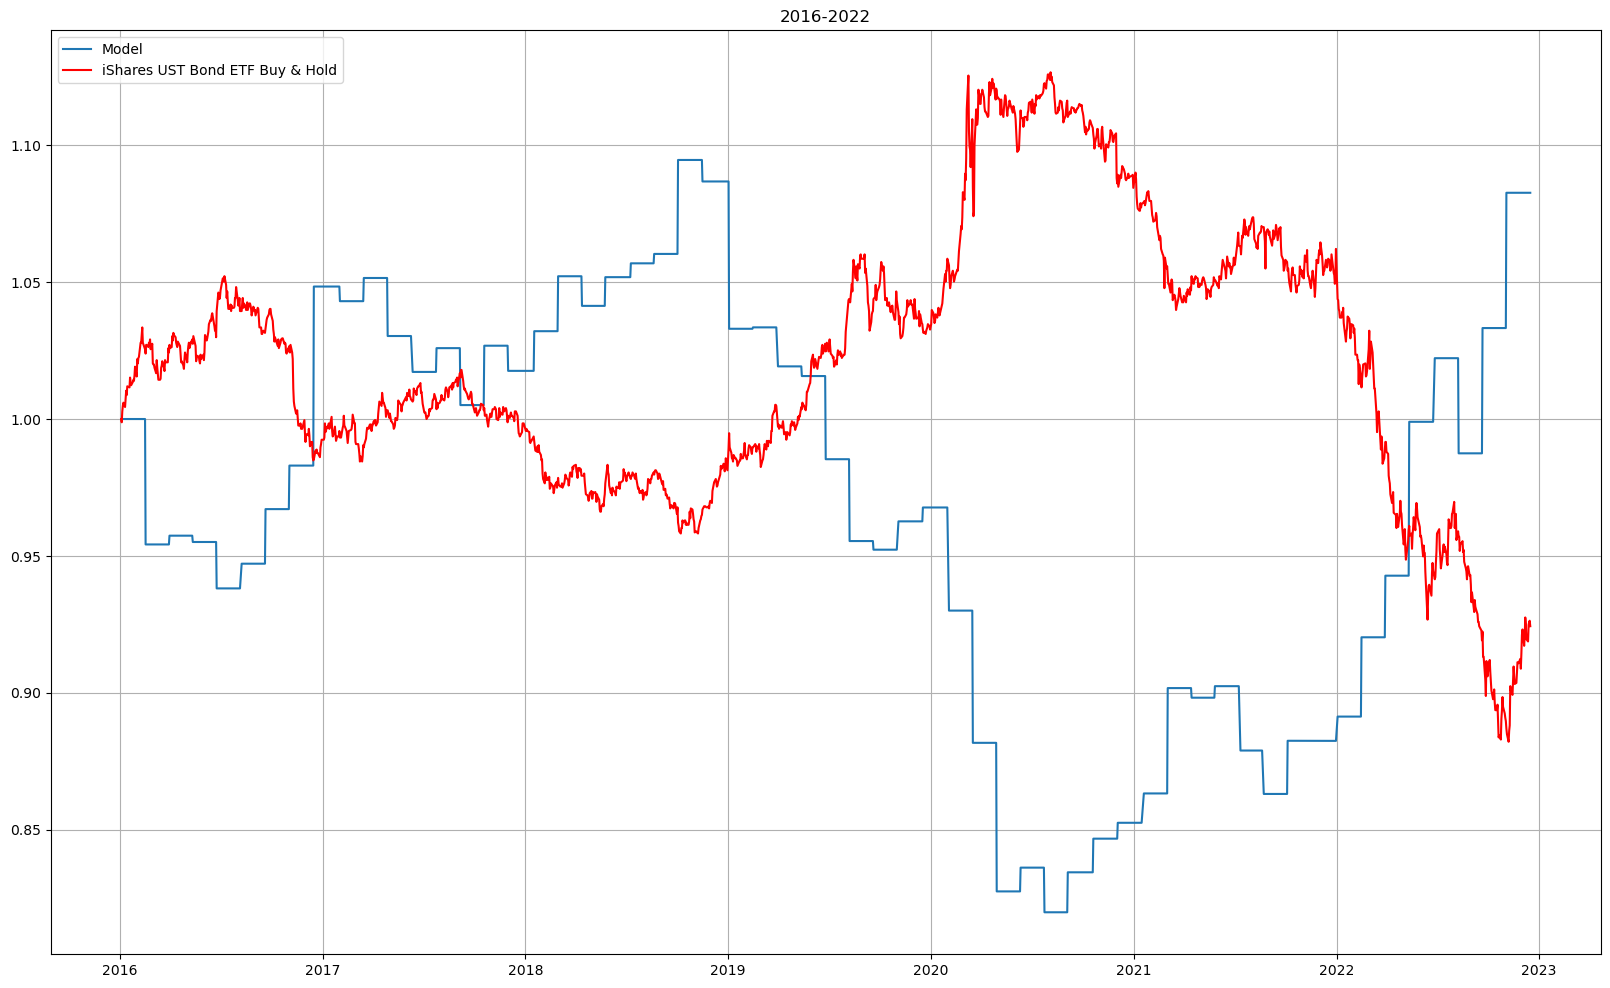

In [106]:
plot_returns(ust_index, strategies, '2016-2022')

In [111]:
def plot_positions(strategies):
    fig, ax = plt.subplots(8, 1, figsize=(20, 20))
    plt.tight_layout()
    counter = 0
    for tenure in [tenures[i] for i in [1, 8, 9]]:
        ax[counter].plot(strategies.index, strategies[f'{tenure}_slope_signal'])
        ax[counter].set_title(f'{tenure} true signal')
        ax[counter+1].plot(strategies.index, strategies[f'{tenure}_position'])
        ax[counter+1].set_title(f'{tenure} position')
        counter += 2
    
    ax[6].plot(strategies.index, strategies['avg return'])
    ax[6].set_title('strategy return')
    ax[7].plot(test.index, test['fed regime'])
    ax[7].set_title('fed regime')

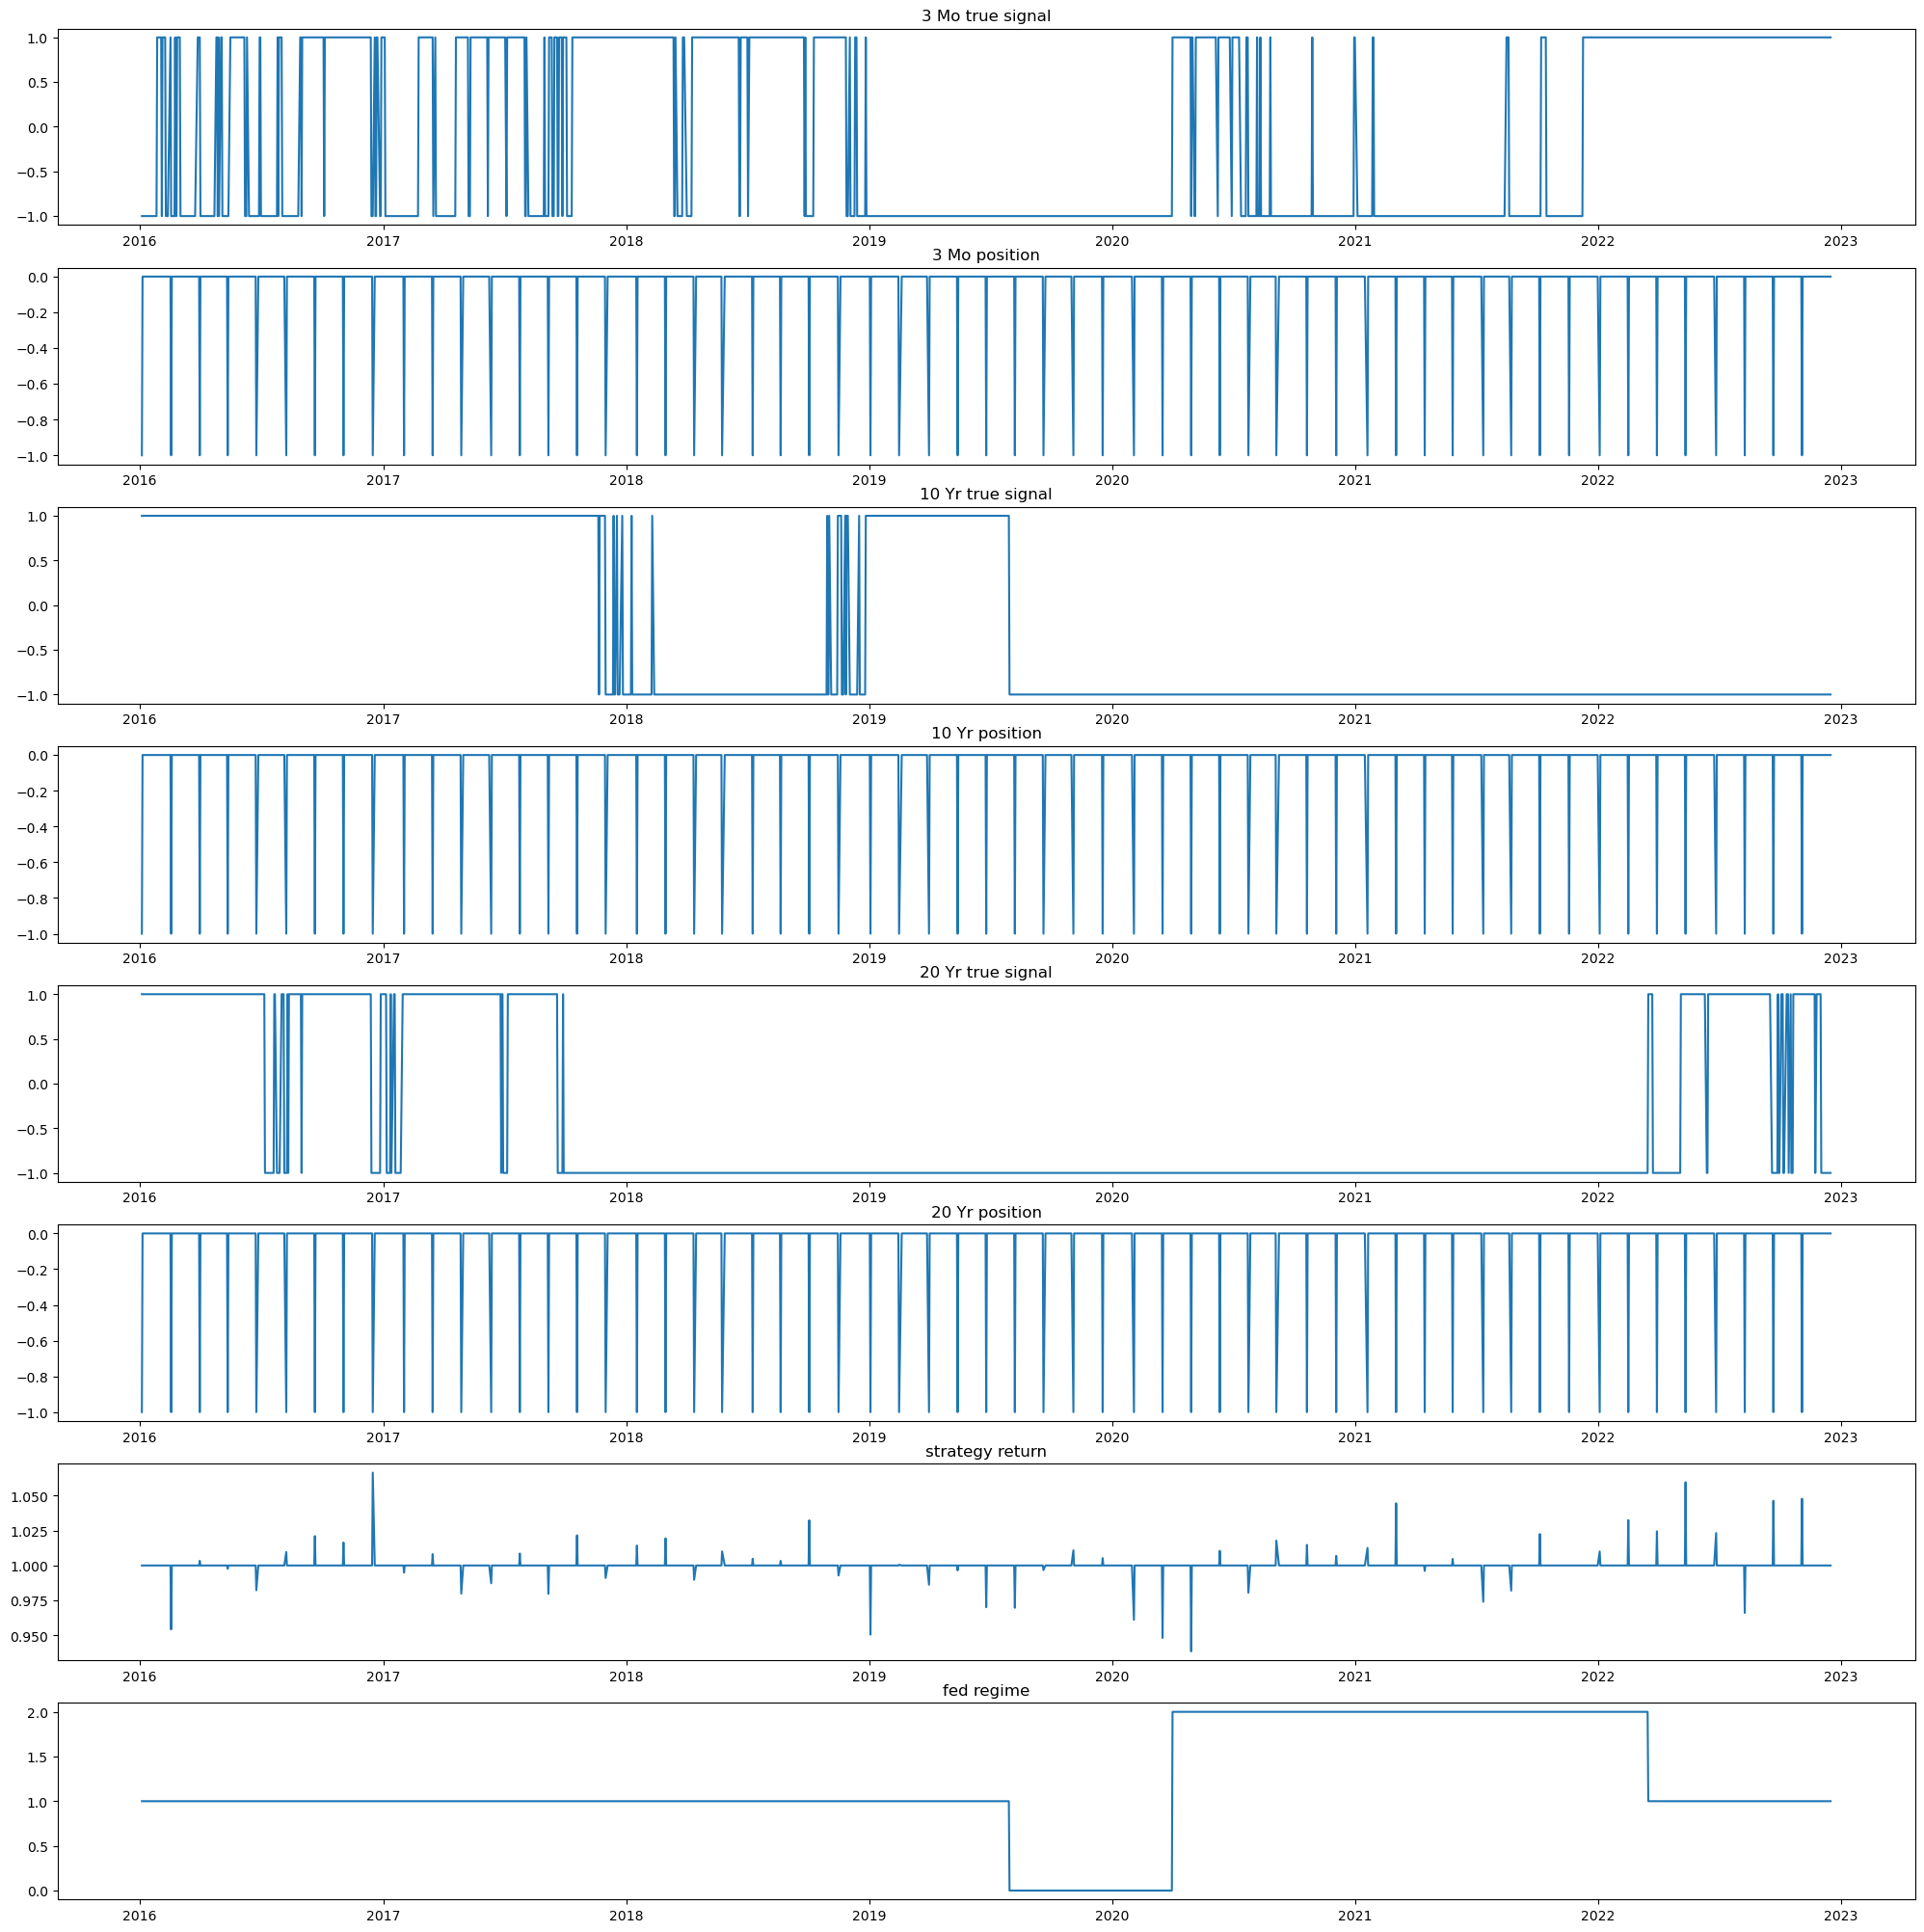

In [112]:
plot_positions(strategies)

In [115]:
ust_index_weekly = ust_index.loc[ust_index.index < '2021-01-01', :].fillna(0)
ust_index_weekly['Close shifted'] = ust_index_weekly.Close.shift(-period+1)
ust_index_weekly['Target'] = ((ust_index_weekly['Close shifted']-ust_index_weekly.Open)/ust_index_weekly.Open).shift(-1)
ust_index_weekly_return = []
for i in range(len(ust_index_weekly)):
    if i%period == 0:
        ust_index_weekly_return.append(ust_index_weekly.iloc[i]['Target'])
    else:
        ust_index_weekly_return.append(0)
temp_df = pd.DataFrame({'return': ust_index_weekly_return}).shift(period)
temp_df =  temp_df.loc[temp_df['return'] != 0, 'return'].dropna()
ust_index_sharpe = temp_df.mean()/temp_df.std()
ust_index_sharpe

0.11306818839273514

In [113]:
strategy_weekly_return = strategies.loc[(strategies.index < '2021-01-01') & (strategies['avg return'] != 1), 'avg return'] - 1
strategy_sharpe = strategy_weekly_return.mean()/strategy_weekly_return.std()
strategy_sharpe

-0.14497802273846794

In [116]:
ust_index_weekly = ust_index.fillna(0)
ust_index_weekly['Close shifted'] = ust_index_weekly.Close.shift(-period+1)
ust_index_weekly['Target'] = ((ust_index_weekly['Close shifted']-ust_index_weekly.Open)/ust_index_weekly.Open).shift(-1)
ust_index_weekly_return = []
for i in range(len(ust_index_weekly)):
    if i%period == 0:
        ust_index_weekly_return.append(ust_index_weekly.iloc[i]['Target'])
    else:
        ust_index_weekly_return.append(0)
temp_df = pd.DataFrame({'return': ust_index_weekly_return}).shift(period)
temp_df =  temp_df.loc[temp_df['return'] != 0, 'return'].dropna()
ust_index_sharpe = temp_df.mean()/temp_df.std()
ust_index_sharpe

-0.10218353189515132

In [114]:
strategy_weekly_return = strategies.loc[strategies['avg return'] != 1, 'avg return'] - 1
strategy_sharpe = strategy_weekly_return.mean()/strategy_weekly_return.std()
strategy_sharpe

0.0653143421510881